In [1]:
import numpy as np
import pandas as pd
import time
from numba import njit

In [2]:
#Checks if current position is not floating.
def CheckBelow(Environment, X, Y, Z):
    return Z == 0 or (Environment[X,Y,:Z] != '0').all()

#Checks if current position has container.
def CheckPos(Environment, Size, X, Y, Z):
    if not ExceedsLot(Size, X, Y, Z):
        return Environment[X, Y, Z] != '0'
    else:
        return False

#Checks if coordinates exceed lot.
def ExceedsLot(Size, X, Y, Z):
    return Size[2] <= Z or Size[1] <= Y or Size[0] <= X or Z < 0 or Y < 0 or X < 0

#Check whether container is in the middle of other containers.
def CheckMiddle(Environment, Size, X, Y, Z):
    return CheckPos(Environment, Size, X, Y - 1, 0) and CheckPos(Environment, Size, X, Y + 1, 0)

#Adds container to environment using state.
def AddContainer(Environment, Size, State, X, Y, Z):
    tempEnvironment = np.copy(Environment)
    if CheckBelow(Environment, X, Y, Z) and not CheckPos(Environment, Size, X, Y, Z) and not ExceedsLot(Size, X, Y, Z) and not CheckMiddle(Environment, Size, X, Y, Z):
        tempEnvironment[X,Y,Z] = State
    return tempEnvironment
    

In [3]:
#Scores board based on priority :)
def scoreEnvironment(Environment):
    result = 0
    for x in range(Environment.shape[0]):
        for y in range(Environment.shape[1]):
            for z in range(Environment.shape[2]):
                if(Environment[x,y,z] == 'H'):
                    #print("yes")
                    #result += (Environment[x,y,z+1:] == 'L').sum()
                    north = (Environment[x,y:,:] == 'L').sum()
                    south = (Environment[x,:y+1,:] == 'L').sum()
                    
                    result += -np.min(north + south)
    return result

#def scoreEnvironment(Environment):
#    result = 0
#    for x in range(Environment.shape[0]):
#        for y in range(Environment.shape[1]):
#            for z in range(Environment.shape[2]):
#                result = (Environment[0,:,:] == 'L').sum()
#                result -= (Environment[0,:,:] == 'H').sum()
#                result -= (Environment[2,:,:] == 'L').sum()
#                result += (Environment[2,:,:] == 'H').sum()
#    return result


#Returns cleared environment
def clearEnvironment(Environment):
    return np.array([[['0'] * Size[2]] * Size[1]] * Size[0])

def singleLegalSpotRemoved(Env1,Env2):
    
    
    firstEnvSpots = np.sum(GenerateLegalMoveArray(Env1))
    secondEnvSpots = np.sum(GenerateLegalMoveArray(Env2))
    #print("FirstEnv: %i, SecondEnv: %i"%(firstEnvSpots,secondEnvSpots))
    if np.array_equiv(Speelveld,newSpeelveld):
        return True
    if (firstEnvSpots - secondEnvSpots) <= 1:
        return False
    return True

def GenerateLegalMoveArray(Environment):
    outputArray = []
    it = np.nditer(Speelveld,["f_index","multi_index"])
    for i in it:
        outputArray.append(legalMove(Environment, Environment.shape, it.multi_index[0], it.multi_index[1], it.multi_index[2]))
    return np.array(outputArray,dtype=bool).reshape(Environment.shape)

#Generate status of board in Boolean array
def GenerateStatusDataset(Environment,dataType):
    return np.concatenate([np.array([dataType == 'H'],dtype=np.float32),np.array(Environment == 'L',dtype=np.float32).flatten(), np.array(Environment == 'H', dtype=np.float32).flatten(), np.array(GenerateLegalMoveArray(Environment),dtype=np.float32).flatten()])

#Checks if move is legal
def legalMove(Environment, Size, X, Y, Z):
    return not CheckPos(Environment, Size, X, Y, Z) and CheckBelow(Environment, X, Y, Z) and not ExceedsLot(Size, X, Y, Z) and not CheckMiddle(Environment, Size, X, Y, Z)


def renderBalk(value,maxvalue,barlength,reverse=False):
    bars = int((value)/maxvalue*barlength)
    if reverse:
        return str('#'*bars) + str('_'*(barlength-bars))
    else:
        return str('#'*(barlength-bars)) + str('_'*bars)


In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

using gpu 2


In [5]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions

In [15]:
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size=100000, eps_end=0.01, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims = 73, fc2_dims=100)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size,*input_dims), dtype=np.float32)
        
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
    
    def choose_action(self, observation):
        indices = self.action_space.copy()
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
    

In [7]:
3*3*2*3 + 1

55

In [17]:
from IPython.display import clear_output
#TODO: Move learning point to after the episode.

Size = (3,3,2)

#High is H
#Low is L

#Generate Environment
c =  [[['0'] * Size[2]] * Size[1]] * Size[0]
cSize = Size[0]*Size[1]*Size[2]*3  #Set observation space size
actionSize = Size[0]*Size[1]*Size[2] #Set action space size
Speelveld = np.array(c)

#Create agent with properties
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=128, n_actions=actionSize, eps_end=0.01, eps_dec=5e-4, input_dims = [cSize + 1], lr=0.001)

scores, eps_history, avg_scores = [], [], []

#Number of games
n_games = 15000

for i in range(n_games):
    score = 0
    done = False
    Speelveld = clearEnvironment(Speelveld)
    step = 0
    containerList = []
    #containerList = [np.random.choice(['L','H'])]*actionSize
    for o in range(actionSize):
        containerList.append(np.random.choice(['L','H']))
    #print(containerList)
    #containerList = ['H','L','L','H']
    
    MemoryDict = {"newContainerType":[],
                  "Speelveld":[],
                  "newSpeelveld":[],
                  "action":[],
                  "reward":[],
                  "done":[]}
    
    
    while not done:
        reward = 0
        
        step+=1
        newContainerType = containerList[-1]
        containerList.pop()
        Observation = GenerateStatusDataset(Speelveld,newContainerType)
        #print(NeuralInput)
        
        #Neural Network
        action = agent.choose_action(Observation)
        
        #Insert while loop waar alle opties geprobeerd worden.
        nnpred = np.array([0]*Size[2] * Size[1] * Size[0])
        nnpred[action] = 1

        posX, posY, posZ = np.where(nnpred.reshape(Size)==1)

        newSpeelveld = AddContainer(Speelveld, Size, newContainerType, int(posX), int(posY), int(posZ))
        
        #Rewarding or punishing agent:
        if singleLegalSpotRemoved(Speelveld,newSpeelveld):
            containerList.append(newContainerType)
            reward = -10
            done = True
        else:
            reward = 3
            
                
        #Exit environment if there's been 2 too many step s (No need to punish, since it already punishes itself above)
        if(step >= Size[0]*Size[1]*Size[2]*2 or not containerList):
            done = True
        
        score += reward

        #Append to memory lists
        MemoryDict["newContainerType"].append(newContainerType)
        MemoryDict["Speelveld"].append(Speelveld)
        MemoryDict["newSpeelveld"].append(newSpeelveld)
        MemoryDict["action"].append(action)
        MemoryDict["reward"].append(reward)
        MemoryDict["done"].append(done)
        
        Speelveld = newSpeelveld
        
        
        eps_history.append(agent.epsilon)
        avg_score = np.mean(scores[-100:])
        
    scores.append(score)
    avgReward = np.mean(MemoryDict["reward"])
    #avgReward = 0
    #avgReward = scoreEnvironment(Speelveld)
    #print(MemoryDict.values())
    #print("Episode %i score %.2f average score %.2f epsilon %.2f"%(i,score,avg_score,agent.epsilon))
    
    
    if not i % 10:
        clear_output(wait=True)
        #printString(content[int((i/10)%50)])
        #if i != 0:
        #    plt.plot(np.average(np.reshape(scores[:-1],(-1,10)),axis=1))
        #    plt.show()
        #print(GenerateLegalMoveArray(Speelveld))
        #print(Speelveld)
        unique, counts = np.unique(Speelveld.flatten(), return_counts=True)
        occurrences = dict(zip(unique, counts))
        if '0' in occurrences:
            print("Empty spots: %i\t"%(occurrences['0'])+renderBalk(occurrences['0'],Size[0]*Size[1]*Size[2],40,reverse=True))
        else:
            print("No empty spots! Almost done!")
        #print(occurrences)
        
        print("Train progress:\t" + renderBalk(i,n_games,40,reverse=True))
        print("Episode %i/%i score %.2f avgReward %.2f epsilon %.2f"%(i,n_games,np.mean(scores[-100:]),avgReward,agent.epsilon),flush=True)
        
        
    
    for l in range(len(MemoryDict["newContainerType"])):
        agent.store_transition(GenerateStatusDataset(MemoryDict["Speelveld"][l],MemoryDict["newContainerType"][l]), MemoryDict["action"][l], avgReward + MemoryDict["reward"][l], GenerateStatusDataset(MemoryDict["newSpeelveld"][l],MemoryDict["newContainerType"][l]), MemoryDict["done"][l])
    agent.learn()
    
    #print(Speelveld)
    
    avg_scores.append(avgReward)
#    x = [i+1 for i in range(n_games)]

#    plot_learning_curve(x, scores, eps_history, filename)


Empty spots: 2	####____________________________________
Train progress:	#######################################_
Episode 14990/15000 score 37.58 avgReward 2.24 epsilon 0.01


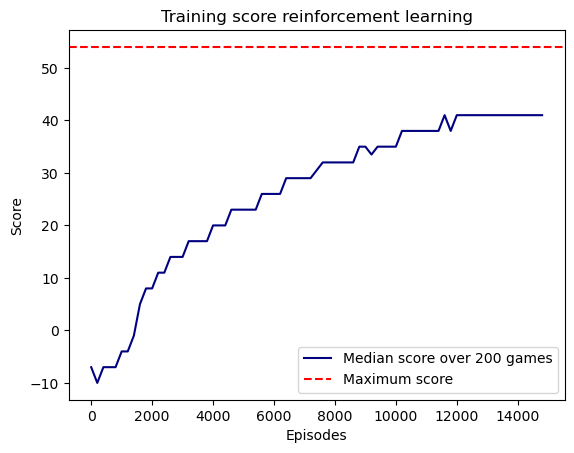

In [9]:
MaxEpisode = min(15000,n_games)
SmoothingFactor = 200

plt.plot(np.array(range(int(MaxEpisode/SmoothingFactor)))*SmoothingFactor,np.median(np.reshape(scores[:MaxEpisode],(-1,SmoothingFactor)),axis=1),color="navy",label="Median score over "+ str(SmoothingFactor) + " games")
plt.axhline(y = Size[0]*Size[1]*Size[2]*3, color = 'r', linestyle = '--',label="Maximum score")

plt.legend()
plt.title("Training score reinforcement learning")
plt.xlabel("Episodes")
plt.ylabel("Score")

plt.savefig('result2.png',dpi=300)



In [ ]:
#Save Model
T.save(agent.Q_eval.state_dict(),"mart.pt")

In [ ]:
#Load Model
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=128, n_actions=actionSize, eps_end=0.01, input_dims = [cSize + 1], lr=0.001)
agent.Q_eval.load_state_dict(T.load("mart.pt"))
agent.Q_eval.eval()
agent.Q_eval.state_dict()

In [ ]:
actions = 17
randomized = [i for i in range(actions)]


indices = [i for i in range(actions)]
randvalues = np.random.random(actions)


In [ ]:
#Zip random values with indices
neuralOutput = dict(zip(f, randvalues))
#Sort neural output
neuralOutputSorted =sorted(neuralOutput,key=neuralOutput.get, reverse=True)


np.random.shuffle(randomized)


In [ ]:
neuralOutputSorted

In [ ]:
neuralOutput

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
content = []
content.append("                                                                    <br>                                                                    <br>                               :XjP:                                <br>                               7B:.MS                               <br>                                 Jv 0F                              <br>                           LGYjJi.vL B:                             <br>                           jMLvrL7:B7.B                             <br>                               ,iL5JBrB:                            <br>                            :iLvYLqUU2S52UL:                        <br>                         rXNYi,.        .:i2GS,                     <br>                       7Bu,     . . . .      :O8                    <br>                      PG.  ............. . .   LB.                  <br>                     MU   ....................  iB.                 <br>                    EX   ......................  UM                 <br>                   :B   ........................  B.                <br>                   Mr  .........................  Zr                <br>                   B. ....... . ..... . ......... 0r                <br>                  ,B   .....     ...    ........  Zr                <br>                  iO  .....  .j:  .  :7  ......   Bi                <br>                  ,B   ..... PBB    .BBi ....... .B.                <br>                   B: .....  :Bi .:  MO. ....... :B                 <br>                   qL ......   7F0kq2i   ....... .M.                <br>                   N7 ..... .q8L:,,,iUOr  ..... . k5                <br>                   B,  ...  :Bk55qXq15BM  .... .  vO                <br>                   PM         .,::::,..   . .    .Bi                <br>                    jZJ:                       ;FB;                 <br>                      ,1BBN2FSSUk252F251F1F5XBBr.                   <br>                      rFr,.....,,:,:,:,:,:,,.i15                    <br>                     Mu                        :Bi                  <br>                    BS     :.. ... ... . .,.    .B.                 <br>                   qO    :0Xr .......... .SPu    iB.                <br>                  vB    .Br  . .........    BL .  rB                <br>                  US  .  ,O.    . . .      u5     ,B                <br>                   BL   :JN0Li.         ,LUBj7   .Bi                <br>                    OXiiBL  i1UPPjY7uJNU17  ,B2:JBr                 <br>                     :LUi..: ,7BU58XG7B1:.,:.,YUr                   <br>                      :,:::.UBui,,MB;,:7MO,:i:::.                   <br>                     .:riri:UO1XkqUJFXk5Xk:ii;ii.                   <br>                        ..::::ii;:,,::i::,:::..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                Bk5q.                               <br>                                Uq iB:                              <br>                            .:,  .N .B                              <br>                           YBJ7YL::B Jq                             <br>                           .2Jvrr7r8Z B                             <br>                                :jkvBvBr                            <br>                           .7YUjYrJJ7LU1F22r.                       <br>                         JEP7:.          ,:jNNi                     <br>                       LML.     . . . .      .PB.                   <br>                      OX   ............. ...   iB:                  <br>                     BY   ..................... :B,                 <br>                    M2   ....................... LO                 <br>                   ;B   ........................  B.                <br>                   M7  .........................  Er                <br>                  .B. ....... . ..... . ......... Er                <br>                  :B   .....     ...    ........  Zr                <br>                  :8  .....  ,N:  .  7U  ......   B:                <br>                  .B   ..... qBB    ,BBi ....... .B                 <br>                   Bi .....  ,G: :i. qk  ....... :B                 <br>                   0Y  .....  .J00SPSr   .......  B:                <br>                   Gr ..... ,MM7:,:,iuMv  ..... . 1X                <br>                   B,  ...  ,BPF5XPXFPMN ..... .  vO                <br>                   1B          ...,..     .      ,B:                <br>                    LM1i..                    .vXB:                 <br>                      .LBO22Skk2FFkFkFkFkFk1SBB:.                   <br>                       Or      ............. ,E7                    <br>                      B:                       Mv                   <br>                     UU  . .Sr ....... ..Si  . ,M                   <br>                     XJ . .B1  ........  ,B7   .B                   <br>                     M7   .Br  . .....   .MU .  M:                  <br>                    .B  .   i0i     .   PY.     ku                  <br>                     MY     YBL        ,BM,    ,B,                  <br>                      FXr  .BLi8Ek5JX2BY:Mj  :2q:                   <br>                       :kEkN:.iBYuEFNrMu..2qP0v                     <br>                     .r:,,: LBui:,MBr,:7ME.,:.:i:                   <br>                     .iri;::UO1XkqUJFXk5kk,:i;i;.                   <br>                        ..::::ii;:,,::i::,::,..                     <br>                                                                    <br>")
content.append("                                                                    <br>                                  .                                 <br>                                YBiqE                               <br>                                 GY LB                              <br>                            LYL;. 7U 0J                             <br>                           :B1r7Yj:B:.B                             <br>                             irr77ruB 0,                            <br>                                 i81BUPY                            <br>                           :YUk5Ui;vrrYU5FS7,                       <br>                        .FN1i,           .,7FE7                     <br>                       uG;    . . . . . .    .UB:                   <br>                     .MU   .................   :Br                  <br>                     Br   ..................... .B:                 <br>                    ML   ....................... 7B                 <br>                   rM   ........................  B.                <br>                   O;  .........................  E7                <br>                  .B  ....... . ..... . ......... 0r                <br>                  :M   .....     ...    ........  Zr                <br>                  :O  .....  ,Mr  .  JS. ......   M:                <br>                  .B   ..... PBB    :BBi ....... .M                 <br>                   8i ...... .F:.:i..1Y  ....... :B                 <br>                   PY  .....  ,UNX1S57   .......  B:                <br>                   8r ..... :BGr:,::iJBU  ..... . jq                <br>                   B:  ...  .GkXSXSPkk0P  .... .  L8                <br>                   7B.            .       .      iB.                <br>                    iZF7:,....           . ...,jZG.                 <br>                       YBj25k15USSkSXFkFkFPF1MB,                    <br>                       M:                     Ni                    <br>                      Nu  .  :.         :.    .B.                   <br>                      B: .  k0   . ...  :B,    Mi                   <br>                      XU  . Ek,.  . .  .rB, . .B.                   <br>                       B:    YYUX. . YPYJ: .  EL                    <br>                       UE      LB.   UB      ,B                     <br>                        Mi     ;0    iE      M7                     <br>                         FSU7,:NBXkjPSB7:iu1P:                      <br>                       ...:v7U8BrYPUk:MBkv7r...                     <br>                     .rr;::.LML:,,BBr,:;0N.,:ir7:                   <br>                      :r;ri:UO2XkqUJFXS1kS:iirii.                   <br>                        ..:::,iii:,,::i::,::,.                      <br>                                                                    <br>") 
content.append("                                                                    <br>                                 :,                                 <br>                                BqrML                               <br>                                .N: BU                              <br>                            77i,  U7 Bi                             <br>                           YBLvYYL.B:,B                             <br>                            :7rri:r2B O.                            <br>                                :jO5BPBU                            <br>                          .rFk5Y7:::::i7jFkUi                       <br>                        :N0Y,.            .:JG2                     <br>                       NN:    . . ..... .     LB7                   <br>                     ,BL   .................   .Bj                  <br>                    .B:  ......................  Br                 <br>                    B;   ....................... iB                 <br>                   YZ   ........................  B,                <br>                   Bi  .........................  Z7                <br>                  .B  ....... . ..... . ......... 0r                <br>                  :M   .....     ...     .......  Or                <br>                  iO  .....  iBY     0M. ......   B:                <br>                  .B   ..... PBB    ,BBi ....... ,B                 <br>                   8i .....   7,:Lu::Li  ....... ,B                 <br>                   PY  .....  iXPUL5kj.  .......  M:                <br>                   8i ..... :BOr::i:iLBN  ..... . Jq                <br>                   Bi  ...  .52kkqXqF5FY ..... .  2X                <br>                   rBi                           LB                 <br>                    ,XSYr;,:,,.... ......,.,,i;5GP                  <br>                       7BvjU1UuUF1F1S15j1FFFJMB.                    <br>                       Z:     :        :      Z                     <br>                      .B:     BS.vZSU :B: .   Ou                    <br>                      .BB:     L0Zi.BBM      8M2                    <br>                       OJ0i          .M,   .0LB,                    <br>                       :O7Jkr:        0:.ijF;0Y                     <br>                        .UYLLYFY:..iqMLLu7Lv0i                      <br>                           7JvivUj7jUviiijL,                        <br>                             ,iGqU275YM7:.                          <br>                       .,::i.:;B7vFY5:8J:,:i::.                     <br>                     .7rrii,2BUi:,BBr,:7MM::iir7:                   <br>                     .i7;ri:UO1XkqUJFXk5Xk:iir;i.                   <br>                        ..::::ii;:,,::i::,::,.                      <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               BXLG;                                <br>                               JS: 0q                               <br>                            ..   rL U0                              <br>                           MqLYL:.5X M7                             <br>                           u277;rrrMU B                             <br>                             .,rJMMUB1Bj..                          <br>                          :v1jjr:,:,.::7J1qF7.                      <br>                        rOkr.              :v8S.                    <br>                      .Mk.    . . ..... . .   iBJ                   <br>                     iBi   .................    MS                  <br>                    :B, .......................  B7                 <br>                    B: . ....................... :B                 <br>                   U0   ........................  B:                <br>                   B:  .........................  N7                <br>                  .B  .......   .....   ......... Z;                <br>                  :M   .....     ...     .......  Or                <br>                  :M  .....  7B2     MB.  .....   B.                <br>                   B.  ..... SBM    .BB:   . ... :B                 <br>                   87 . .     :.:Yu7,i: .,.   .. ,B                 <br>                   EJ  .  .77iYB577u0qj82XZ5.  .  Br                <br>                   M: .  jMYruB5E::,Mr..   7B,  . Y8                <br>                   Bi   qN      FBLMM       qX    5k                <br>                   :B;  M.  .   .jZB,       8i  .2B                 <br>                    .Sk7BN     .   ;F0ji. .PB;;5NJ                  <br>                       ;B8E:,,       .7Uq225;SB                     <br>                       M, ;P1qqJ.             B,                    <br>                      ,B       iU0Y.      .   21                    <br>                      .B   .  .:J81XNj:.   .  Uq                    <br>                       Bu   :PqL:   ,r1SN2.  .B,                    <br>                       .Bj   .          ..  :B7                     <br>                         jZv,             ;X0.                      <br>                           ;25L:,. . ,,7jFv.                        <br>                              :BBGZUBPBr.                           <br>                       .,iii,:7B77FY5:8Ui,:ii:.                     <br>                     .7rrii,2Bui:,BBr,:7MM::iir7:                   <br>                     .i7;ri:UM1PkNUJFXk5XX:iir;r.                   <br>                        ..::::ii;:,,::i::.i:,..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               rMYEJ                                <br>                               :Mi SM                               <br>                             .   r1 jM                              <br>                           qBYLY7,7X 87                             <br>                           rqYY;rr:N2 B                             <br>                               .:uGUB7Br                            <br>                           ,7JUJY7YLL7jU555r.                       <br>                         YPk;,           .:vqqr                     <br>                       uM7.   . . . . . .    .FB,                   <br>                      MS   .................   iBi                  <br>                     BL   ................... . .B,                 <br>                    MJ   ....................... 7B                 <br>                   iM   ........................  B.                <br>                   O;  .........................  0r                <br>                  .B  ....... . ..... . ........  Er                <br>                  :M  ......     ...     .......  Er                <br>                  :O  ...... :Zr  .  L2  .......  B:                <br>                  .B   ..... qBB    :BBi ....... .B                 <br>                   Mi .....  .q: :i..SU   . . .  :B                 <br>                   0Y  ...     UPS5qSr        ..  B:                <br>                   Zr .      GEi:,:,:JBSYjF57   . uP                <br>                   B:   .kX1MBGqj2UULSB:rr,:FG.   LO                <br>                   uB  :Br  , :Br   :Pr      j8  :B,                <br>                    7NuB.      :FSPBu,       iBrFO,                 <br>                      .0i   .    .:iJFNSX:  .BB..                   <br>                       kB,             ,:.  uLN                     <br>                      .O:kXY1Fu:.         .   kL                    <br>                      ,B  .:..iPBBUJi,     .  uN                    <br>                       B:   YUUYY:ivkNGkXq;   B:                    <br>                       rB:  .,         ,,,   OP                     <br>                        :8F.               7Bj                      <br>                          :UkY:        ,rF5r                        <br>                            ,rJ8OSFYZFBUv:                          <br>                       .,ii:.,;BLJPjNiMj:.:i::.                     <br>                     .7rrii.UBji:,BBr,:7MO,:iir7i                   <br>                     .iriri:UO1XXqUjSkS1Xk:iirir.                   <br>                        ..::::iii:,,::i::,i:,..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               iUUr                                 <br>                               B5.jM.                               <br>                                vJ .B,                              <br>                           ,7r;: .S..B                              <br>                           BMvv7L:JB ;Z                             <br>                            :i:r7JY1M,B                             <br>                             ,rrL5BFNSMSjYi.                        <br>                         :Uq27:,.      .,iYXPJ                      <br>                       ,Mq;                 .7M2                    <br>                      uB:    . .............   SB                   <br>                     PE   ................. .   vB                  <br>                    2M   .....................   PS                 <br>                   :B   .......................   B                 <br>                   GY  .........................  Or                <br>                   B. ............... ..........  Zr                <br>                  ,B  .......    ...   . .......  0r                <br>                  iM  ...... .r.  .  ,:  .......  Mi                <br>                  ,B   ..... SBB    .BBi ....... .B.                <br>                   B, .....  rBv    .BB. ......  :B                 <br>                   0L  .....   i1NPXj:   ....... .B                 <br>                   0L .....  L0ji:::vUF, ........ Xj                <br>                   B,  .... :BEU2S1FU1BB  .... .  7O                <br>                   qk     .   ::i:i:i:,   . .     Br                <br>                    ZZ7.                       :LBY                 <br>                     .LUB1F5117;Y7vrJLr:vL7j10ZU7                   <br>                       UE .,,BEBBB:7BMBPBL::.rB                     <br>                       B      iLL     ,B.     07                    <br>                      ,Mr:            FU     ;2P                    <br>                       B;NXi.   .   .qZ   :YMi0r                    <br>                       10 :1XPXNqO1SBBUFFP57 rB                     <br>                        UG:       .         FM                      <br>                         .L5r,          .iJF:                       <br>                            71222vvrY7k1SY,                         <br>                       ,,i:: ,LB5FMNOLBS:.,i::,                     <br>                     .7rrii.UBji,.BBr.:7MO,:iirri                   <br>                     .ir;ri:UM1XPNUjSXk1PX:iir;r.                   <br>                        ..::::iii:,,::i::,i:,..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               .1UP.                                <br>                               LB,,BJ                               <br>                                 2i MU                              <br>                           ;kYvL:.ur B:                             <br>                           FB7vLYLiBr,B                             <br>                             ..,,vLYB:B,                            <br>                            .,rr7jONNXMFJYi.                        <br>                         :UN17:,.      .,iYXPJ                      <br>                       ,Mq;                 .7M2                    <br>                      uB:    . .............   SB                   <br>                     PE   ................. .   vB                  <br>                    2M   .....................   PS                 <br>                   :B   .......................   B                 <br>                   GY  .........................  Or                <br>                   B. ............... ..........  Zr                <br>                  ,B  .......    ...   . .......  0r                <br>                  iM  ...... .r.  .  ,:  .......  Mi                <br>                  ,B   ..... SBB    .BBi ....... .B.                <br>                   B, .....  rBv    .BB. ......  :B                 <br>                   0L  .....   i1NPXj:   ....... .B                 <br>                   0L .....  L0ji:::vUF, ........ Xj                <br>                   B,  .... :BEU2S1FU1BB  .... .  7O                <br>                   qk     .   ::i:i:i:,   . .     Br                <br>                    ZZ7.                       :LBY                 <br>                     .vUB1FF1YJYJ7L7L7Lrr7Lj10ZU7                   <br>                       jN .:.ir.,i:::::iri::.rM                     <br>                       B:    7B   .    7B     Mi                    <br>                      .Bu  .  UE127BNYU8:    .B5                    <br>                       BBr     .:  E0:.     .FBi                    <br>                       J0Y2r.       :B    :UUkG                     <br>                        YX7vN7     :Nr  :SU7SZ                      <br>                          rL7XuLrL7UUiijPurJ:                       <br>                            rvLkSvr:7vqJL7.                         <br>                       :,i:: ,vBuUGX0rB1: ,i::,.                    <br>                     ,vrrii.UBJi,.MBr.:7MO,:iirr;                   <br>                     .iriri:UM1XPNUjSXk1PX:iirir,                   <br>                        ..::::iii:,,::i::,i::..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                SSqL                                <br>                                BS jB                               <br>                             .   :N 7B                              <br>                           7BUuU7.iE 2U                             <br>                           iMYLrJLiB5 B                             <br>                               .ir77B:O:                            <br>                            .:7r7LE0qXMFJYi.                        <br>                         :UN17:,.      .,iYXPJ                      <br>                       ,Mq;                 .7M2                    <br>                      uB:    . .............   SB                   <br>                     PE   ................. .   vB                  <br>                    2M   .....................   PS                 <br>                   :B   .......................   B                 <br>                   GY  .........................  Or                <br>                   B. ............... ..........  Zr                <br>                  ,B  .......    ...   . .......  0r                <br>                  iM  ...... .r.  .  ,:  .......  Mi                <br>                  ,B   ..... SBB    .BBi ....... .B.                <br>                   B, .....  rBv    .BB. ......  :B                 <br>                   0L  .....   i1NPXj:   ....... .B                 <br>                   0L .....  L0ji:::vUF, ........ Xj                <br>                   B,  .... :BEU2S1FU1BB  .... .  7O                <br>                   qk     .   ::i:i:i:,   . .     Br                <br>                    ZZr.                       :LBY                 <br>                     .7XB5SF1U5Jj7L7L7LLYvLj1qBY7                   <br>                       M;..:..,::;iiiiii::::.,Oi                    <br>                      0u     :          ,.    .B.                   <br>                      B: .  S0   . . .  :B,    M;                   <br>                      PU  . ZP,.  ...  .rB: . .B.                   <br>                       B:    YJ2q, . YNYj: .  ZY                    <br>                       uE      LB.   1B      ,B                     <br>                       .Mi     rk    :G      B7                     <br>                         FXU7,:0Br7r72B7:iU1q:                      <br>                       ,..:v7U8BY1MNGrMBkL7r....                    <br>                     :Lrr::.YMv:,.BBr.:;EN.,:irr;                   <br>                     .iriri:UO1XPNUjSXS1Xk,iirir,                   <br>                        ..::::iii:,,::i::,i::..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                iEU87                               <br>                                :B, Mj                              <br>                            .::.  8: B:                             <br>                           :B57JY;.8 :M                             <br>                            rYLLLYrGB B.                            <br>                                 rjrBiFi                            <br>                            ,iL7v7PGXX85JYi.                        <br>                         :UN17:,.      .,iYXPJ                      <br>                       ,Mq;                 .7M2                    <br>                      uB:    . .............   SB                   <br>                     PE   ................. .   vB                  <br>                    2M   .....................   PS                 <br>                   :B   .......................   B                 <br>                   GY  .........................  Or                <br>                   B. ............... ..........  Zr                <br>                  ,B  .......    ...   . .......  0r                <br>                  iM  ...... .r.  .  ,:  .......  Mi                <br>                  ,B   ..... SBB    .BBi ....... .B.                <br>                   B, .....  rBv    .BB. ......  :B                 <br>                   0L  .....   i1NPXj:   ....... .B                 <br>                   0L .....  L0ji:::vUF, ........ Xj                <br>                   B,  .... :BEU2S1FU1BB  .... .  7O                <br>                   qX     .   ::i:i:i:,   . .     Br                <br>                    ZZr.                       ,LBY                 <br>                     .r8B5SF5U5Jj7L7L7LLYvLu5XB2;                   <br>                      :k:..:,::::;iiiiiiiii:,.vX                    <br>                     rB                        7B                   <br>                     B:    ;S: ... . ..  Yj  .  Oi                  <br>                     B. . vB. .........   JM  . qU                  <br>                    rX    7B:  ......... .1N    :O                  <br>                    Gj  .   0u  . . . . :M:      B.                 <br>                    ,B;    jB1          ,BB.   ,8S                  <br>                      FSi.:BUvUU1vvrJvkUU;MJ,:UX:                   <br>                       :2SF; .LB5FMNOLBS: .UFk7                     <br>                     :7::,, UBJi,.BBr.:7M8..,,:ir                   <br>                     .iri;::UM1XPNUjSXk1PX,iiri;,                   <br>                        ..::::iii:,,::i::,i::..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               iUUr                                 <br>                               B5.jM.                               <br>                                vJ .B,                              <br>                           ,7r;: .S..B                              <br>                           BMvv7L:JB ;Z                             <br>                            :i:r7JY1M,B                             <br>                             ,rrL5BFNSMSjYi.                        <br>                         :Uq27:,.      .,iYXPJ                      <br>                       ,Mq;                 .7M2                    <br>                      uB:    . .............   SB                   <br>                     PE   ................. .   vB                  <br>                    2M   .....................   PS                 <br>                   :B   .......................   B                 <br>                   GY  .........................  Or                <br>                   B. ............... ..........  Zr                <br>                  ,B  .......    ...   . .......  0r                <br>                  iM  ...... .r.  .  ,:  .......  Mi                <br>                  ,B   ..... SBB    .BBi ....... .B.                <br>                   B, .....  rBv    .BB. ......  :B                 <br>                   0L  .....   i1NPXj:   ....... .B                 <br>                   0L .....  L0ji:::vUF, ........ Xj                <br>                   B,  .... :BEU2S1FU1BB  .... .  7O                <br>                   qk     .   ::i:i:i:,   . .     Br                <br>                    0q:.                       .rML                 <br>                     .BBPFXF5U5Jj7L7L7LLYvLuFFMBj                   <br>                     NL. .,:,::::;iiiiiii;i:,. iNi                  <br>                   :B:                          .Bj                 <br>                  uM:    :Li ..... . .... :Ur     XO                <br>                 YZ     qkr:............. :ruM: .  7G               <br>                 Br  .  Br   .............   B.    .B.              <br>                 ;B    .rBi     . . . .    .BN.    85               <br>                  jBi,XBj:r57:          .ru1irZM:iMM                <br>                   ,5YL     v5121vvrJvXUkY,    :JJi                 <br>                       .,::: ,LB5FMNOLBS:.,i::.                     <br>                     :7;;ii.UBji,.BBr.:7MO,:iirrr.                  <br>                     ,iriri:UM1XPNUjSXk1PX:iiri;:                   <br>                        ..::::iii:,,::i::,i::..                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                   .i                               <br>                                  7Br50                             <br>                                   jU rB                            <br>                              ,r7:. :E LO                           <br>                              BZ7YJU:1q M:                          <br>                               ;r:iiriB:;S                          <br>                                .:iYG8PB2B                          <br>                           .J2X2Yri::,::7LSXX7.                     <br>                         .qGL,              ,LPEi                   <br>                        FB;   . . ....... .    .k8                  <br>                       8G  . .................   7B.                <br>                      MX  .....................   rB                <br>                     JM  .......................   MY               <br>                     B, .........................  :B               <br>                    LG  .......................... ,B               <br>                    8;  .......   ... . .........  .B               <br>                    M: ....... .   .     ......... iB               <br>                    B: ...... :BB     YM: .......  LG               <br>                    q7 .....  rBB     BBL  ....... G;               <br>                    0j  .....  .:i11J.v7  ....... .B                <br>                    B: .....  :12J77uNu   .......  B                <br>                    B   .... LBkL;;iiiUBj .......  Mi               <br>                    GL     . .:rLS51U2j07  ... .   Bv               <br>             ::,     NF:.                         iB.               <br>           qqUJ2PqSkJuMBM81UYL7r::.,....     ..:rU5                 <br>         ,Br     ..      .:ir;7vuj25kSS5F1ZkX11UMB7                 <br>         B;  . .                         ...      L1FN:             <br>         Mu      .,,:,:   . ... . . . . .            ,Br            <br>         .0SvY :qEU2UUUBN7 ...............   Lju;     :B            <br>           :iX0S:      8L   ............... .iq8kY     B.           <br>                       ,B:   .............    B ,B:Xr:N8            <br>                        .Gk.    . . . .     iBr  ru:Y1r             <br>                          iqU:           .rE2.                      <br>                            ,OB517r;7vjjB1Y.                        <br>                       ::i:,iBr;77BBYJ77M5 :::,.                    <br>                     :vrri:.BX.,,.OBi.,.;B:,iirr7.                  <br>                     :iriri:YMPqXO1LZ0kqGP,iiri;:                   <br>                        ..::::r77i:.:rvri,:::.                      <br>                                                                    <br>") 
content.append("                                                                    <br>                                     ivL:                           <br>                                     BP F8                          <br>                                      7P LO                         <br>                                rMJYYr rq ZL                        <br>                                :MYrrrv7BL B                        <br>                                  .:;LULjB.M.                       <br>                              .7UUYL7YYPjZGBU.                      <br>                            L0kLi.         .71GP7                   <br>                          iBU.     . . .       :jBu                 <br>                         G8.  . ........... . .   kB.               <br>                        BX   ...................   7B               <br>                       8F   .....................   U8              <br>                      vB  .........................  B,             <br>                      B:  .........................  SU             <br>                     iB  ....... . ................. F2             <br>                     2S .......     ...   .........  qL             <br>                     Zj  ..... .GB.  .  ,  ........  B.             <br>          .SEXPPY,   F1 ...... :BB.    OBS ........ :B              <br>         iBr   rJBi  FU  .....  :i .,. BB; .......  ZJ              <br>         Br      kE  B: .....  .rYkSqZk:   ....... .B               <br>         B:  . . ,N7:Z   ...  FB2;::,:LBL  ....... ,B               <br>         vB,    .  ;MB,   . . :jUS0qNFUUBL ....... .B.              <br>          iMXFi      7OF:.        ...,::,  ..... . .B.              <br>             :M8:      iZ021Y;i:.                  FU               <br>               rBE.       .irLJXSPkF2UYY7r::::,rvUNB:               <br>                 vBq,             ..::;r7YU211L77:  Bi              <br>                   r8Gr. ... . .             rL     iB              <br>                     .jB7 ............. . . .:B5    LB              <br>                       q2  ...............  EBr    jB,              <br>                       rM   ............... S1   2ML                <br>                        0k   .............  EL  M5                  <br>                         LP,    . . . . .   .B5PZ                   <br>                          EB2;.           .7U7                      <br>                         2O:71PZ2LLiriiiLUGGB                       <br>                        .BL:,:JBr7YuJLBBY;::Bu.:.                   <br>                     .7r:Y80EPEr..,.,.:1qXZNX:ii7r.                 <br>                      :ri:,:::.,:::i::,,,:::,iirri                  <br>                         .,:::;i;;r;r;ri;ii::,..                    <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                ir.                 <br>                                               uBrBr                <br>                                          ,ri   O..B.               <br>                                         ,B2rjL  O 1Y               <br>                                          ,7Y7iJ;N,:8               <br>                                        ..  .Lqr:B:,N               <br>                                   :Y2XU1uUJj72B5BvL7               <br>                                 jPU:.          .LFB7               <br>                               UB7.   . . . . .     L8P.            <br>                             .BU   ............. .    7Bu           <br>                            :B:   ................. .   8O          <br>                           .B:   .....................   N0         <br>                      :7L::Bi  ........................   B:        <br>                    ,MX7i7SB   .........................  FN        <br>                   .B:     XM.  ...     ................. LZ        <br>                   Bi  . .  XG ...  .2:  ... ...........  k1        <br>                   1P   .  7G   .. .BB5       . .......   B.        <br>                    Xq   . Bi  .    UL     PB2 ........  uM         <br>                     B: .  LM     ,:vrYUY iBB: ........ ,B.         <br>                     XU  . .B,   qB2;ri7kB,.   .......  MY          <br>                     :B   . 2q   :5Xqu7:,rB,  .......  11           <br>                      Br .   B7     :LF8X2BB .......  LM            <br>                      rB  .  .XFj:      .::.  ......  M;            <br>                       M7  .   :vk0X7:.      . ...   .B.            <br>                        Bi ....    :vFNNkvi.         Z2             <br>                        Mj ..... .     .:LUqqqrL7v7JBJ              <br>                       ,B  ..........        0BiLYv,M:              <br>                       7M  .............   Lkk5     Mi              <br>                        B,  .............  BU.    .NZ               <br>                        ,B,  . .........  jZ   r2Pq7                <br>                         .Ni    . . ... . Nj  MU,                   <br>                          ;BG7.            XM0:                     <br>                         0OirLMMULr:i::,rLYUB                       <br>                        YB.,,.qM:7j2uJNBU7i.UB,::.                  <br>                      ,i1B1JU1Br..,.,.,ZPLjYMZ,:r77.                <br>                       ::rU1UY:,:i:i::,,rujU7::r;r:                 <br>                           .,,:i;iriri;i:::,:::.                    <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                         :XGi       <br>                                                   LPU:  EU B:      <br>                                                   8X.j5 .q FU      <br>                                                    iU:r2 8 0i      <br>                                         i75S0NZkFYi  L,rBL B.      <br>                                      ikZ27,......:r2uLB:B.uk       <br>                                    LM1:              .7EBuk        <br>                                  :M5   . ......... .    ,B5        <br>                                 LP      ............. .   7Br      <br>                                5B7YX5u.  ...............   .Bu     <br>                               YB2i:,:JBi  .................  B7    <br>                              ,Bi      .B.  ................. :B    <br>                             ,MB   .   :Z    ...............   B:   <br>                            J2LM. .   .uBB0 . . .............  Zr   <br>                           7q B, .  .NUUBB7  .   ............  B.   <br>                           F7Z7     N:  :.     77 ........... 7B    <br>                            Bq     UBSuUY5q5  BBB. ......... .B,    <br>                            B.  . iEiOXi::iPM.X2  ......... .Bv     <br>                           S1  .  Mi  7O0j:,0P   .......   :B7      <br>                           B, .  ,B,    :5G2SB. .......   7B:       <br>                          28  ..  :0Pr     iYr .......   Nq         <br>                         qE  ....   :18U:       .....   MU          <br>                        r8   .....    .Lk0L,   . . .   vB           <br>                        B:  .........    .YqPr.       :B.           <br>                        B, .............     ;BGL7ii:58.            <br>                        PP  .............  .G7Bi,iYr5B              <br>                         MY  . .........   BUi.     0L              <br>                          Pq.   . . ...  .BY   .iiL82               <br>                           ,B2,          ,B  rFFYvi                 <br>                           ;ESBk2Lr:...  .ZXU1                      <br>                         :JB:NU.ivUSk5jNBUqGL..:,,                  <br>                       :BBU::YB,,,,.,. ZM.:iSB7,;;7r                <br>                       :M8kGqNY::i:i::,7PkXk187iir;:                <br>                           .:.:irir;ri;:::i::.:..                   <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                 iXY<br>                                                          v8FX   B:N<br>                                                 .::,.    iM,rB  B .<br>                                            iuPXkFU22SSG17  5;,O M r<br>                                         :kZSr,         :7qU:O:;B7 B<br>                                       r80:      ..... .   .7MBiB UU<br>                                      NN,   .     ....... .   LBjYP <br>                                    7Bi  . .  .:.  .........   .BN  <br>                                   5B.  .   :XGXG5. ........... .Bi <br>                                 LBF   .  .XMv   FB  ........... .B.<br>                               .BF.      LBY      B, ............ :B<br>                               BL     .70Z.  .   PZ  ...........   B<br>                               B:  .7FPL:   .   uM  .............  2<br>                               ,M:Y0j:         5E    ............  0<br>                                BOi       .rSS;kS.GB: ........... .B<br>                              1O,      .rBB2r7BMiBBB. ..........  07<br>                            XMY   .   vE7;Mqi.7M ..  ..........  ZE <br>                          iBY   ... 7BB    LMS7B.    .......   :M5  <br>                         YB.  ..... i.Y8i    r82  .........  .0B:   <br>                        :B   .......   :MZ.      .......   ,UBL     <br>                        G5  ...........  rBu    .......  .087       <br>                        0P  ............   UM7   ... .  ,B7         <br>                        .B, .............    Yk7.      7B:          <br>                         7B.   ........... .Mq2BPkvr:7k0            <br>                          iB:   . ....... :M2,i  .;iUBi             <br>                            BEi.         7M.       :Bv              <br>                           rE1BXqU;.     kN  Y1uUjkX,               <br>                         :UB:G5 ij5GEqFEBGMBBL,::,                  <br>                       .BB1i:YB,,.,.::.MB,:rSBr.:ir7:               <br>                       .OGqMEZJ::i:i::,7NPPX5O7iirii.               <br>                           .,.:ir;rrr;r:::i::.::,.                  <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                            ,     LY<br>                                                           B2Oi  MNi<br>                                                 .:,,.     GY Mi F7 <br>                                            :jkSS5uUUFFE2v. iS M E: <br>                                         :SEF;,         :7qF,2L:Bk k<br>                                       rGq:    . ..... .   .7ZB:B rM<br>                                      Pq,   . ........... .   LBj;q <br>                                    7Bi  . ..... ...........   .Bq  <br>                                   1B.  .....       ........... .Bi <br>                                 LB5   .....  .L2Fv  ........... .B.<br>                               .B5.   . .   :UOJi:U0. ........... :B<br>                               BL         iG07     Gu ..........   B<br>                               B:     :7kEq:       Br ...........  U<br>                               :M  r58Pu:.   .    Xr  ...........  N<br>                                EBPJi           iBBk. ........... .B<br>                              LMv,        .:J5. BBBB. ..........  q7<br>                            kGL.       i1qBBSLXBP,    .........  0N <br>                          iBY    .  :XBU,  7ZUrB     .......   :M1  <br>                         YB.  ......SijX:    rZu  ....... .  .qM:   <br>                        :B   ..... .   :80.      .......   .UMv     <br>                        E1  .........    rMj    .......  .qZ7       <br>                        NX  ............   uO7   . . .  ,B7         <br>                        .B, .............    YS7.      7B:          <br>                         7B.   ......... . .OXUBkSv;:rFq            <br>                          iM:   . . ..... :MU,i  .iiuBi             <br>                            B0i.         r8.       :B7              <br>                           r02BkXui.     Fq  L2UujkS.               <br>                         :LB:Z2 :J2Z0P10BEMMBv,i::                  <br>                        BB2i:YB,..,.:,.MB,:r5Br.::ir7.              <br>                       .EGP80EY::i:i::,7PkXk2G7:irir:               <br>                           ...::;;riri;:::i::.::,..                 <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                            :,    ,7<br>                                                           NBq8   B7<br>                                                 ,::,.     rB 7M  B <br>                                            iUNqqX255XPMSY.  B S;iP <br>                                         :qOXr,         :vG0:,0 BB :<br>                                       rMZi    . ..... .   .YqB,Br.B<br>                                      EZ:   . ........... .   YBF:q <br>                                    vBi  ...................   ,B8  <br>                                   kB.  ......... . ........... .Bi <br>                                 YBX   ..... .       ........... .B.<br>                               .BX.   .....    :2PEU  ........... :B<br>                               BJ  ...      LBBPr:.FB. ..........  B<br>                               Bi       .:YMB;      BU  .........  F<br>                               :B  .:uPOqqu:   .   .B: ..........  G<br>                                2BEZX7i       .   vBv ........... .B<br>                              L85L.             iBBB  ..........  Z7<br>                            qMJ,        ,r2MMNj.BE.   .........  88 <br>                          iBj    .  .rk02u:UB0GBq.   .......   :BS  <br>                         jB.  ......O5PB:    rG1  .........  .GB:   <br>                        :B   ..... .   :MG.      .......   ,1BL     <br>                        OS  .........    7BU    .......  .ZML       <br>                        G0  ............   2BL   ... .  ,Bv         <br>                        .B, .............    jPL.      7B:          <br>                         vB.   ........... .B05BNPYr:7PZ            <br>                          ;B:   . ....... :B1,;  .ri2Bi             <br>                            B8i.         7B.       :BL              <br>                           r8FBq02r..    PZ  JS52U0P,               <br>                         ,YB:MS iUSM8Ek8BMBBBY:i::.                 <br>                        BBki:jB:,,,,::.BB,:rXB7.i:;7v.              <br>                        EMEBOOU::i:i::,LZN0qSM7ii7rri.              <br>                           ...:irrrr7rr::iiii.:::..                 <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                 ;Eu<br>                                                          YBqZ  .B:8<br>                                                 ,::,.    ;B:7B  B .<br>                                            i5GEENFSF00MkL  qr:B B 7<br>                                         :0MN7,         :L8F:BirBY B<br>                                       7BMi    . ..... .   .vBBrB SS<br>                                      OO:   ...............   jB5jZ <br>                                    LB;  ...................   ,BM  <br>                                   PB.  ..................... . .Br <br>                                 uBP   .....   .     ........... .B.<br>                               .Bq.  ......     iYj7  ........... iB<br>                               Bj  .....    vBB0PULOB. ..........  B<br>                               Bi        .:XBMr     0B  .........  X<br>                               iB  .:J1GBMMY        GZ ..........  M<br>                                FB0OO57:.          MB  .......... .B<br>                              YBPY,              JBB  ..........  8L<br>                            EBu,         :75EX7 MB,  ..........  MM <br>                          ;Bu    ... iUENXYPBBBBB7  ........   iBq  <br>                         uB.  .....,MP8Bi    rOP  .........  .MBi   <br>                        :B   ........  :BM.      ........  ,SBJ     <br>                        MX  ......... .  vB5    .......  .MBY       <br>                        MG  ............   5BY   .....  ,BY         <br>                        .B, .............    u0Y.      LB:          <br>                         YB,  ............ .B8kBGNYri7EM            <br>                          rBi   . ....... :BF:r  ,r;FBi             <br>                            BM;.         vB.       iBY              <br>                           7MPB08F7,     EO  jXPP5Z0.               <br>                         :jBiBX i1XMMGqMBBBBBJ:i::.                 <br>                        BBqi:UB:,,,,::.BB,:7PB7.iir7Y,              <br>                        8BGBMB1:iiii:i,Y8ZZEXBLir7rvr.              <br>                           ...:i777r7r7i:irii:ii:,.                 <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                             rL     <br>                                                      iYr   SE7B    <br>                                                      B5iNi L2 Or   <br>                                                       57 q. G Mi   <br>                                          :v25GPSFkk1Y: iY XZL M    <br>                                       :505L,.     ..iY2vM1:B U5    <br>                                     :80;     . . .     .rG8U.8     <br>                                    qM:    ........... .   iNB      <br>                                  :BY   . .     .........    JE     <br>                                 iB:   .   :r:   ...........  ;B.   <br>                                iB, . .  ,8qj1M:  ...........  iB   <br>                               7B, . .  LB;   .Bi  ...........  Fk  <br>                              ON  .    qZ   .  Mj ............. :B  <br>                             BL  .   :BU   .  :B   ............ .B  <br>                            :B     7Ek:   .  .B:   ............ :B  <br>                             ML  JOF,        qL i1: ..........  P5  <br>                              k0qJ.      ikkLJNBBB: .........  iB   <br>                             .Xk       JBBr;LB:;L  .........  iB.   <br>                           .BB:   .  rGvrSqv,5E   .........  uB     <br>                          LB;  ... iBB    :U5BB  .......   ,Mq      <br>                         58   ... .UrYEr    .:. .......   UBi       <br>                        7B   .....    .SOU.    . .....   Bj         <br>                        B:  ....... .   .Y81:    ....   Bu          <br>                        B: ........... .   i2q;        81           <br>                        2M  .............    :qBXLrii7Gr            <br>                         NS   ............ :BqXL iLLvB.             <br>                          U0,   . ....... .BY       q1              <br>                           .B2:           Bi   i7YJZY               <br>                           i02Bk1Lr:.    ,B, U8ri,.                 <br>                         ,vB:0U.iLUENSUEBUZBBU.....                 <br>                        BB5i:YB,,,,.:,.GM,,i2Br.iirr7.              <br>                        P8k80ZJ::i:i::,vXXkS2G7:iri;:.              <br>                           ...,:r;ririr:::i::.:::..                 <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                       .NOq         <br>                                                 i0UY  :B k0        <br>                                                 YBi70, G.,B        <br>                                                  .Yu G:2,:O        <br>                                        .rY1U2U1J7. :S 1B 1L        <br>                                     .28ZYr::,:,:iY2vBMYN B         <br>                                   :E87.             .7B0M,         <br>                                  XM:     ....... .     :O5         <br>                                ,B7  .   . ...........    ;Bv       <br>                               :B. qGX8X. ...............   B2      <br>                              .B. BU   FB. ...............   BY     <br>                              Bi UM     BY ................  .B     <br>                             0q  B.  .  0L .................  Z7    <br>                            kO  S8  ..  BS  ... ............. NU    <br>                           Zq  ,B: ..   2Bi  .   ...........  Mr    <br>                          ;M  :Bi .   L7r2,   .i. .........  :B     <br>                          :B ,B:     MB8U7i  vBBr ........   Br     <br>                           7GB:     BB::i;5B,YBv  ........  MF      <br>                            B;     O2LGSr:.LB    .......   8P       <br>                           01     1P   rS8XrBE  .......  .B5        <br>                          BB   . :BP.    .iUq7 .......  :Bi         <br>                         Bq.  .. .:iZEY.       ......   B:          <br>                        N2   .....   ,7kkJ,    . . .   ZN           <br>                       ,B   ....... .   ,7kXY:        uB            <br>                       :B  ........... .   .:UMqLL::iZO             <br>                        Br  .............   :.OB:YjY;B.             <br>                        .Br  ............. .BXY     :B              <br>                          MS    . .......  UP    ,;5B,              <br>                           :BY.            B   SqU7:                <br>                           iZ0B5XYri:::,:7qMriBi                    <br>                         :YB:01.iYj5FXUEBUGPXY:.::,.                <br>                       .BB5i:YB,,,,.,. EO.:i2Br.iir77               <br>                       .EZX8EZJ::i:i::,vPPXX1O7iir;r:               <br>                           .,.,:r;r;rir:::i::,::,..                 <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                   .:               <br>                                                  7BjB:             <br>                                            rBUu  .B 7M             <br>                                            7BriFL 2r M             <br>                                              75,i2j7 B             <br>                                        ,::,,   u;iBi,8             <br>                                    ;Xq0F1jUj5k57BuM q:             <br>                                 ,kO5:.         .,jFMB              <br>                                qBr      . . .      .Y0F            <br>                              :Bv   ............. .    LBJ          <br>                            .YB.   ...................   BE         <br>                          LMuUSXi   ...................   OS        <br>                          B:   ,B7 .....................   B,       <br>                          B.    :B.   . .................  Xk       <br>                          M, ..  NP      ................. JZ       <br>                          G:  .   LB7iBi ..   . .........  1X       <br>                         .Br ..  L1Y7BB: .     .........   B:       <br>                        .MBi  . LB   L.    ,BBi ......... JB        <br>                        LBq  .  E; rLjjPPi XBB. ...... . .B.        <br>                         Bk     O.BBY::ir0k .  ........  B:         <br>                         kL  . :B  UNPU7:,Uq   .......  Mj          <br>                         Zi .  iM    ,YPEX2BL .......  E5           <br>                         B:  . :Bj:.     ,:: .......  :B            <br>                        ,Bi ... ,:YFSv:       .....   XS            <br>                        Bq: ....    .LPGqui,         ,B.            <br>                       LO   .......     ,iUXPXYii:ii1B.             <br>                       15  ......... .       ,BMLUjY;B              <br>                       ,B   .............   F5X:    ,B              <br>                        YB   .............  BJ    .jB:              <br>                         rB7    . ... . .  i0   JE07                <br>                           U8;.            XG  M2                   <br>                           :8EB15ULiiiiiLUBYY5EJ                    <br>                         :jB:N1.iLvUU2LPB7PFi,.,,:.                 <br>                       :BBU::YB,,,,.,. 0G,:rSB7.ii77,               <br>                       .OOkGNEY::i:i::,7XXXk1O7iirii                <br>                           .,.,irir;rir:::i::.:...                  <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                             ..                     <br>                                            Bu5q                    <br>                                        .   SY qS                   <br>                                      LBLYY: ki B.                  <br>                                      :0JriYj:Z 0r                  <br>                                         :7r.PB Jr                  <br>                                   :7JUL7rrPB7B 0.                  <br>                                70E1Lr::::,:iL5NB:                  <br>                              2Gj.              ,Y05:               <br>                            rBv    . ....... .     iN0.             <br>                           1B.  .................    iBi            <br>                          kG   .....................   B:           <br>                         7B   .......................  :B           <br>                  :k5ENL,M.  .........................  8r          <br>                 iB,  .iBZ    ..... . ................. uY          <br>                 7B      UO;i, ...   . ... . .........  F2          <br>                  MU  .   irMM  . ,O1 . .   .........   Mi          <br>                   Br  .   7k. .  BBG  .  77 ......... ,B           <br>                    Bi  . :B  .   :Y     PBB. .......  82           <br>                    .B.    Mr    iLU5qqS.rG: .......  :B            <br>                     8Y .  7B  .BBu::::YMi   ......   B:            <br>                     LM  .  B;  :U5qX5L;rB0  ....... j0             <br>                      B.  . ;B     .:iuu1Z0  ......  XL             <br>                      P5     qGvi.           .....   Bi             <br>                       B. ..  :7FFq1Jr:.            rM              <br>                       uB  ..     .:ijukPkUYi:.,,:rjBi              <br>                       jBi  . . .       ..iirMBYuuL.rG              <br>                       Mi  ......... . .     .ML    ;B              <br>                       U0   ..............  8Bv    rB,              <br>                        Bj   .............  J5   YN2                <br>                         P0,    . . . . .   NL  GF                  <br>                          ,Sk:             7SZvSM                   <br>                           iBNMJUuYr;iirUFB;  :,                    <br>                         iUB:NS.iLvJYJ7UBiSkv: ...                  <br>                       rBBU::YB,,,,.,. EG,:rkBv,;rv,                <br>                       :M8kZP0Y::i::::,7XXkk1O7i;ri.                <br>                          ..,.:irir;rir:::i::.,..                   <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                      YvL                           <br>                                     :Bi,B:                         <br>                                  .    O, B.                        <br>                                .B1UuY. G 7G                        <br>                                 XqvYvLiEF B                        <br>                                    ,rvrvB k.                       <br>                               ,LYLvLvJO5MEBv                       <br>                            ,5NSv:,. .   .,iYkXu,                   <br>                          .NZi                ,rq8r                 <br>                         YB;   . ........... .   ,08                <br>                        5M. . ................. .  LB               <br>                       2M  ..................... .  UO              <br>                      :B. .........................  B,             <br>                      GY ..........................  Fj             <br>                     .B   ....... .................  UF             <br>                     Y0  ......    ...   . ........  kU             <br>                     U5 ....... Yq, .       .......  8r             <br>           .rJvjL.   j1  ..... .BBi    jBX ........ .B              <br>          XNLii:LBu  7N .....   uL  .  MB1  ....... 20              <br>         E2      .ES:8:  .....  ,r2NqZv:.  ....... .B.              <br>         B:   . .  .FB  ..... vBkr::::U8r  ....... .B               <br>         rM7         B.  . .  iE5SSSF17uBu .......  M.              <br>          .BPYq1L,   ;B7.        .::ii7r7.  .....   B.              <br>            i;. iX5r  .JXPuLi:..                   LE               <br>                  .YML   .irj1kFk21UJrr:::.....,irkM0               <br>                     YM,         .,i;v7UuSSkSFYJjL: rB              <br>                      .Z, . . .              ,i.    ,B              <br>                       B.  ..... ... . . .   :UBX   0J              <br>                       B7   ...............   iB7  .B               <br>                       :B:   .............   .BjO,  51              <br>                        :M2     . . . .     iBi :BUiMF              <br>                          rqJ.           .r55     ;Y,               <br>                           7BZM25LL7LLJu0GB                         <br>                         ruB:Nk,iLYJLL:LB:S0L:.:.                   <br>                      irBMu::LB,.,,,,..Z8,:rXBY:77:                 <br>                      ,rM8S0X0L:::::::,vPXXX5M7iii.                 <br>                          .,:,:irir;rir:::i:,...                    <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               ;22;                                 <br>                               B1.jM.                               <br>                                Lu .B,                              <br>                           ,77r: .S..B                              <br>                           BMvv7L:JB rZ                             <br>                            :i:r7jJ1B,B                             <br>                             ,rrL5BFNSMSjYi.                        <br>                         :UN27:,       .:iLXPY                      <br>                       ,Mqi                 .7M2                    <br>                      UB:    . ........... .   SB                   <br>                     qE   ...................   vB                  <br>                    1M   .....................   Pk                 <br>                   :B   .......................  .B                 <br>                   GY  .........................  Or                <br>                   B. ............... ..........  Zr                <br>                  :B  .......    ...    ........  Er                <br>                  iO  .....   r.  .  ,:  ......   Mi                <br>                  ,B   ..... SBB    .BBi ....... .M.                <br>                   B, .....  rB7    .BB.  .....  :B                 <br>                   0L ......   i2NqPJ:   ....... .B                 <br>                   N7 .....  L0ui:::7UF,  ....... kJ                <br>                   M,  .... :BEU2S1FU2BB .......  7G                <br>              .    2U     .   ::i:i:i:,   . .     0:  .,.           <br>           UNk5NkYL1BEr,.                      :7BB7jX2U18L         <br>         :B7.   :i:. :2NEFSF5U1jJ7L7L7L7YLLUSXZXJ, .:.   .PO        <br>         B:  .           .,:,::::;iiiii;i;i:,.         .   kP       <br>         B.         .                           ...        1M       <br>         LB;:: ,5q5kkXNq   . ... ... . ... .  rBUFkPkY .i:2M        <br>          .71BPZr     .B. .................   ML     jEEPYi         <br>              .        1B  . ........... .   uB                     <br>                        2Mi     . . . .    .qB                      <br>                          LU7.           iYU:                       <br>                           YB8OuuYJYJYUqBOB                         <br>                       ..7UB:NX,iv7777:rB:XEL:..                    <br>                     i7iBMj:,LB,.,:,:..G8,:rqBJi7.                  <br>                     ::rMG5NkNL::::i::,vPPPXSBLi:                   <br>                         .:::::ir;r;rir::::,.                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               .12k.                                <br>                               LB,,BJ                               <br>                                 1i MU                              <br>                           rXYvL,.jr B:                             <br>                           SB77LLLiBr,B                             <br>                             ..:,vYYB:B.                            <br>                            .,r;7JOqNkMSjYi.                        <br>                         :UN17:,.      .,iYXPY                      <br>                       ,Mqi                 .7M2                    <br>                      UB:    ... ......... .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   ......................  qS                 <br>                   :B   .......................  .B                 <br>                   8Y  .........................  Or                <br>                   B. ..........................  Zr                <br>                  ,B   .....     ...     .......  Er                <br>                  iO  ...... .;.  .  ,:  .......  Mi                <br>                  ,B  ...... FBB    .BBi ....... .M.                <br>                   B, .....  rBv  . .BB. ....... :B                 <br>                   0L  .....   i2NPXY:   ....... .B.                <br>                   07 .....  LEu;:::vUS,  ....... XJ                <br>                   B,  .... :B0U2F5FU2BB  .... .  7M                <br>                   Nk     .   ::i:i:i:,   . .     Br                <br>                    F2:,                       .;G7                 <br>                     2BEqFk5FU5jJ7L7L7LvLvYUSkEBB,                  <br>                  ;Nq;   .,:,::::;iiiii;iri:,.  :Sqr                <br>             :1U202,                              :UE2S2.           <br>            UBi,,.       . ... . ......... .         ..rB7          <br>           :B        .YB; . ...............   qL.       :B          <br>           SX  .    1OrNM    ........... .   uBYNY   .   B,         <br>           :B.     PM   UM;     . . . .    .NB   B; .   5M          <br>            :BUjUONG      L27.           iYU:    :O8M2u8k           <br>              ,:: .        YBGOuUYjYjY1qBOB          ,:             <br>                       ..72B:0X,i77v77:rB:XZL,..                    <br>                     :7;BMJ:,LB,.,:,:..G8,:rqBjir                   <br>                     .:rM85qXNL:::::::,7PqPXSBvi,                   <br>                         .,::::ir;rir;;::::,.                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                kkXv                                <br>                                BS jB                               <br>                                 :0 rB                              <br>                           7B2uU7.iE 2u                             <br>                           iMYvrYL;B5 B                             <br>                               .:r77B:O:                            <br>                            .:7r7LE0qkMFjYi.                        <br>                         :UN17:,.      .,iYXPY                      <br>                       ,Mqi                 .7M2                    <br>                      UB:    ... ......... .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   ......................  qS                 <br>                   :B   .......................  .B                 <br>                   8Y  .........................  Or                <br>                   B. ..........................  Zr                <br>                  ,B   .....     ...     .......  Er                <br>                  iO  ...... .;.  .  ,:  .......  Mi                <br>                  ,B  ...... FBB    .BBi ....... .M.                <br>                   B, .....  rBv  . .BB. ....... :B                 <br>                   0L  .....   i2NPXY:   ....... .B.                <br>                   07 .....  LEu;:::vUS,  ....... XJ                <br>                   B,  .... :B0U2F5FU2BB  ......  7M                <br>                   0X     .   ::i:i:i:,   . .     Br                <br>                    ZZr.                       :LBY                 <br>                      iXBG21FU5jJ7L7L7LvLvYuF8BYi                   <br>                      rX7,.:,::::;iiiii;i;i:,rSF                    <br>                     MU                        :Bi                  <br>                    Bk     :.. . ....... .,.    .B.                 <br>                   qO    :PPr .......... .S0j    iB.                <br>                  LB    .Br    .........    BL .  rB                <br>                  2k     ,8     . . . .    Y5     ,B                <br>                   BL   :YESr.           i7BJ7   .Bi                <br>                    MPiiBi rBGOuUYjYjY1qB8M  M2:uBr                 <br>                     ,YJ:,LB:0X,i77v77:rB:Xq:.rur                   <br>                      :,MOY:,LB,.,:,:..G8,:rPBr..                   <br>                     .:rMGFqXNL:::::::,7PqPqkBvi.                   <br>                          ,::::ir;rir;;::::,.                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                ;ZUG7                               <br>                                :B, Mj                              <br>                            .::.  8: B:                             <br>                           :BF7jY;.8 :M                             <br>                            rYLLLYrGB B.                            <br>                                 rurBiFi                            <br>                            ,iL7L7PZXk8FjYi.                        <br>                         :UN17::..     .,iYXPY                      <br>                       ,Mqi                 .7M2                    <br>                      UB:    ... ......... .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   ......................  qS                 <br>                   :B   .......................  .B                 <br>                   8Y  .........................  Or                <br>                   B. ..........................  Zr                <br>                  ,B   .....     ...     .......  Er                <br>                  iO  ...... .;.  .  ,:  .......  Mi                <br>                  ,B  ...... FBB    .BBi ....... .M.                <br>                   B, .....  rBv  . .BB. ....... :B                 <br>                   0L  .....   i2NPXY:   ....... .B.                <br>                   07 .....  LEu;:::vUS,  ....... XJ                <br>                   B,  .... :B0U2F5FU2BB  ......  7M                <br>                   0X     .   ::i:i:i:,   . .     Br                <br>                    ZGr.                       :YBY                 <br>                     .rkB1F55U1jJ7L7L7LvL7YU5qBLr                   <br>                       Mi..:..,::;iiiiii::::.,8;                    <br>                      Nu     :          ,.    .B.                   <br>                      B: .  k0   . . .  :B,    M;                   <br>                      Pu    ZX,.  ...  .rB, . .B.                   <br>                       B:    LJUq. . YNJj: .  ZY                    <br>                       UE      LB.   1B      ,B                     <br>                       .Oi     7P    iM      M7                     <br>                         jujr:iqB7YLL5Bv::uJU:                      <br>                         :PB2BM:,7777i.1B5BB7.                      <br>                     .rrBML:,vB..,:,:..0G.:iXBui:                   <br>                      ,rM8FNXNL:::::::,7PqPqkB7:.                   <br>                         ..::,:ir;rir;;::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                2XSY                                <br>                                EP LB.                              <br>                                 .E :B                              <br>                           rBUJUv,,O J5                             <br>                           :GuLLYY;MG B                             <br>                                ,iYLB:G:                            <br>                            .:7r7vqEXkMkJYi.                        <br>                         :UN17:,.      .,iYXPY                      <br>                       ,Mqi                 .7M2                    <br>                      UB:    ... ......... .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   ......................  qS                 <br>                   :B   .......................  .B                 <br>                   8Y  .........................  Or                <br>                   B. ..........................  Zr                <br>                  ,B   .....     ...     .......  Er                <br>                  iO  ...... .;.  .  ,:  .......  Mi                <br>                  ,B  ...... FBB    .BBi ....... .M.                <br>                   B, .....  rBv  . .BB. ....... :B                 <br>                   0L  .....   i2NPXY:   ....... .B.                <br>                   07 .....  LEu;:::vUS,  ....... XJ                <br>                   B,  .... :B0U2F5FU2BB  ......  7M                <br>                   0X     .   ::i:i:i:,   . .     Br                <br>                    ZGr.                       :YBY                 <br>                     .7UB2555UUJJ7L7L7L7v7Yu5qEj7                   <br>                       UZ .:,,,::iiiii:i:ii:.7B                     <br>                       B7    :X        :2     Bi                    <br>                      .Bi  . :B:.:..,,.GP     BS                    <br>                       BB     iEkvNBLjEJ     LBi                    <br>                       LBGi       7B.      .UBB                     <br>                        7GBN       LE     ;BBP                      <br>                          :BB:   .:ML   .2B5.                       <br>                           ;MMB8BBEuMBB8BOO                         <br>                        .rUB,N2.,i:i:i.iM,kZv,                      <br>                     .rrBBJ:,LB,.,,.:..Z8,:rqBUi:                   <br>                      ,rM8FNPNL:::::::,7PqqqkB7:.                   <br>                          .::,:ir;rir;;::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               .q1k:                                <br>                               iBi M2                               <br>                                 uL XX                              <br>                           78JvL:.7L Mi                             <br>                           UBY77uY:B7.B                             <br>                             ..,:77vB,B,                            <br>                            .:r;7LOPqkMSjYi.                        <br>                         :UN27:,.      .,iYXPY                      <br>                       ,Mqi                 .7M2                    <br>                      UB:    ... ......... .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   ......................  qS                 <br>                   :B   .......................  .B                 <br>                   8Y  .........................  Or                <br>                   B. ..........................  Zr                <br>                  ,B   .....     ...     .......  Er                <br>                  iO  ...... .;.  .  ,:  .......  Mi                <br>                  ,B  ...... FBB    .BBi ....... .M.                <br>                   B, .....  rBv  . .BB. ....... :B                 <br>                   0L  .....   i2NPXY:   ....... .B.                <br>                   07 .....  LEu;:::vUS,  ....... XJ                <br>                   B,  .... :B0U2F5FU2BB  ......  7M                <br>                   0X     .   ::i:i:i:,   . .     Br                <br>                    ZGr.                       :YBY                 <br>                     .7UB2555jLLY77r777i77Yu50Zj7                   <br>                       j5 .:,:u:.,.,,,,2rii:.:O                     <br>                       B7     M5.rPUY ,B.     B;                    <br>                      .BB:     LNZi.MBM      G85                    <br>                       M:Mi          .M,   .M:17                    <br>                       UP.1E7:        Z:.rUN.rB                     <br>                        uN:.ijNUi..iEBUu1;. 2M                      <br>                          7Y:  :LJrY2r:  .rj:                       <br>                           LBE077r7iii71OGB                         <br>                        .r2B:0k,:7r7r7,rB:XZv,                      <br>                     .rrBBJ::LB,.,:,:..G8,:rqBUi:                   <br>                      ,rM8FNXNL:::::::,7PqqqkB7:.                   <br>                          .::,:ir;rir;;::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               :U1L                                 <br>                               BE.rB:                               <br>                                i2. Bi                              <br>                           :UL7i .u. B.                             <br>                           BMv7vLirB,:M                             <br>                            .:,;rUYjM,B.                            <br>                             ,i;7UBFPXMSjYi.                        <br>                         :UN1v:,.      .,iYXPY                      <br>                       ,MN;                 .7MU                    <br>                      UB:    . ......... . .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   .....................   XS                 <br>                   :B   .......................   B                 <br>                   8Y  .........................  Or                <br>                   B. ....... ..................  Zr                <br>                  ,B  ......     ...   . .......  Er                <br>                  iO  .....   i.  .  ,:   .....   Mi                <br>                  ,B   ... . FBB    .BB:   . ... .M.                <br>                   B, ...    iB7    .BB..,.   .. :B                 <br>                   NL  .  .77:.r2XXkLFk0USGS.  . .B                 <br>                   0v    SOLrvSqB:,,Br .   7B,    Xj                <br>                   B,   0F      EBruG       qP .  7M                <br>                   NX   B.  .   .SBB,       M7    Br                <br>                    EG; U5     .   i50Ji.  1F  :YBY                 <br>                     .7JBBk:,.       .ruXUZBJkEu7                   <br>                       UX 7q1qNv.          ..;B                     <br>                       B.      i5NL.          G7                    <br>                      :B   .  .:J85PqU:.   .  jE                    <br>                      .B.   iqNL:   ,7FSEY.   87                    <br>                       5B    .          .,   uB                     <br>                        UMi     . . .      .0B                      <br>                         .vU7.           iY2:                       <br>                           YBG8UUYJYjJ2qB8B                         <br>                        .rUB:0P:i77777:rB:XZ7,                      <br>                      rrBBj:,LB,.,:,:..ZO,:rNBui:                   <br>                      :rM8SNPNL::i::::,7qPPqXM7:.                   <br>                          ,::::ir;ririi::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               ;uY,                                 <br>                              .B7:XZ                                <br>                                uv iB                               <br>                           .7r:. :F .B                              <br>                           BMv7;7iUB vE                             <br>                           .ii:77YYXM.B                             <br>                             ,77Y5B5N5MFjYi.                        <br>                         :UN27:,       .,iYXPY                      <br>                       ,MN;                 .7MU                    <br>                      UB:    . ......... . .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   .....................   XS                 <br>                   :B   .......................   B                 <br>                   8Y  .........................  Or                <br>                   B. ....... ..................  Zr                <br>                  ,B  ......     ...   . .......  Er                <br>                  iO  .....   ;.  .  ,:  ......   Mi                <br>                  ,B   ..... SBB    .BBi ....... .M.                <br>                   B, .....  rBv    .BB.  . .... :B                 <br>                   NL  . .     iU0qPJ:         . .B                 <br>                   0v .      YZJi:::7JSUjjF57     Xj                <br>                   B,   ,kX10BOYY1UU7uBi77,:FO.   7M                <br>                   NX  rBr  : :BJ,,:LBr      uM   Br                <br>                    E07B       :2uSBL.       iN.LBY                 <br>                     .78,   .    .:rY50kX,  .BBv7                   <br>                       YB:             ,:.  2XZ                     <br>                       MrNNj5SY:.         .   Z7                    <br>                      :B  ,:..iqBBUY:,     .  JE                    <br>                      .B.   JU2YY:ivkGGSPq;   87                    <br>                       5B   .,         ,,:.  uB                     <br>                        UMi                .0B                      <br>                         .vU7.           iY2:                       <br>                           YBG8UUYjYjJ2qB8B                         <br>                        .rUB:0P:i77777:rB:XZ7,                      <br>                      rrBBj:,LB,.,:,:..ZO,:rNBui:                   <br>                      :rM8SNPNL::i::::,7qPPqXM7:.                   <br>                          ,::::ir;ririi::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               iLi                                  <br>                              GB,YNi                                <br>                               v5: 2F                               <br>                            ,,   JJ 7F                              <br>                          .BNvLL7i0B 27                             <br>                           UYi:;ijL0G,M                             <br>                            .:LY5NM1EFM1uYi.                        <br>                         :UPu7,,       .,iYXPY                      <br>                       ,MN;                 .7MU                    <br>                      UB:    . ......... . .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   .....................   XS                 <br>                   :B   .......................   B                 <br>                   8Y  .........................  Or                <br>                   B. ....... ..................  Zr                <br>                  ,B  ......     ...   . .......  Er                <br>                  iO  .....   ;.  .  ,:  ......   Mi                <br>                  ,B   ..... SBB    .BBi ....... .M.                <br>                   B, .....  rBv    .BB. ....... :B                 <br>                   NL  .....   iU0qPJ:   ....... .B                 <br>                   0v .....  L0u;:::vUS,  ......  Xj                <br>                   B,  .... :BE22S1FU2BB .......  7M                <br>                   NX     .   ::i:i:i:,   . .     Br                <br>                    E8r.                       :YBY                 <br>                     .vUB15152riYv7rJLr:7vvu5EZu7                   <br>                       UE .,,BZBBB:7BMBXBL::.;B                     <br>                       B      iLL     ,B.     E7                    <br>                      ,Br:            5U     r2P                    <br>                       Br0Xi.   .   .qZ   :YMi0r                    <br>                       20 :5kPXNqO5SBBUS5qF7 rB                     <br>                        UG,       .         FM                      <br>                         .7ur.           :LU:                       <br>                           YBG8uuLJLJY2qB8B                         <br>                        .rUB:EP:i77777:rB:XZ7,                      <br>                      rrBBj:,LB,.,:,:..ZO,:rNBui:                   <br>                      :rM8SNPNL::i::::,7qPPqXM7:.                   <br>                          ,::::ir;ririi::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                              .::                                   <br>                              BFiF1                                 <br>                              iU7 :Ei                               <br>                                ,Ui X7                              <br>                          .NULL7iiBk Gi                             <br>                          .O7i::iJ7EkiM                             <br>                            iL2FE8Gj8SMUuYi.                        <br>                         :ukJr..       .,iYXPY                      <br>                       ,MN;                 .7MU                    <br>                      UB:    . ......... . .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   .....................   XS                 <br>                   :B   .......................   B                 <br>                   8Y  .........................  Or                <br>                   B. ....... ..................  Zr                <br>                  ,B  ......     ...   . .......  Er                <br>                  iO  .....   ;.  .  ,:  ......   Mi                <br>                  ,B   ..... SBB    .BBi ....... .M.                <br>                   B, .....  rBv    .BB. ....... :B                 <br>                   NL  .....   iU0qPJ:   ....... .B                 <br>                   0v .....  L0u;:::vUS,  ......  Xj                <br>                   B,  .... :BE22S1FU2BB .......  7M                <br>                   NX     .   ::i:i:i::   . .     Br                <br>                    EGr.                       :YBY                 <br>                     .rXB1555U1Jj7LvL7LvL7Lu1NBY7                   <br>                       Mi .:..,::;iii;ii::i:..O;                    <br>                      Nu     :          ,.    .B.                   <br>                      B:    k0   . . .  :B,    M;                   <br>                      Pu    GX,.  ...  .rB, . .B.                   <br>                       B:    YJ2q, . YNJj: .  EY                    <br>                       uE      YB.   5B      ,B                     <br>                       .Oi     7q    iM      M7                     <br>                         Juu7::qB7YLv5BL::ujU:                      <br>                         :XB2BM::7r7ri.1B1BBr                       <br>                      rrBML:,7B..,:,:..08.:iPBji:                   <br>                      :rM8FNXNL::i::::,7qPPqXM7:.                   <br>                          ,::::ir;ririi::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               iU2r                                 <br>                               B5.jB.                               <br>                                vj .B,                              <br>                           ,7ri: .S..B                              <br>                           BMvv7v:jB ;Z                             <br>                            :i:r7JJ1B,B                             <br>                             ,rrL1B5NSMFjYi.                        <br>                         :UN27:,.      .,iYXPY                      <br>                       ,MN;                 .7MU                    <br>                      UB:    . ......... . .   SB                   <br>                     qZ   . .................   vB                  <br>                    2M   .....................   XS                 <br>                   :B   .......................   B                 <br>                   8Y  .........................  Or                <br>                   B. ....... ..................  Zr                <br>                  ,B  ......     ...   . .......  Er                <br>                  iO  .....   ;.  .  ,:  ......   Mi                <br>                  ,B   ..... SBB    .BBi ....... .M.                <br>                   B, .....  rBv    .BB. ....... :B                 <br>                   NL  .....   iU0qPJ:   ....... .B                 <br>                   0v .....  L0u;:::vUS,  ......  Xj                <br>                   B,  .... :BE22S1FU2BB .......  7M                <br>                   NX     .   ::i:i:i::   . .     Br                <br>                    N0:.                       .7ML                 <br>                      BBP5S5FU5Jj7LvL7LvLvYuFSMBJ                   <br>                     NL. ..:,::::;iii;i;iii:,. i0i                  <br>                   :B:                          .BJ                 <br>                  uM:    :Li ..... ... .. :1r     X8                <br>                 YZ     NPr:. ........... :;uM: .  78               <br>                 Br  .  B;   ........... .   B.    .B.              <br>                 ;B    .;Bi     . . . .     BP.    O5               <br>                  JBi,PBY:7Ur.           iYY:7GM:iMM                <br>                   ,FJY    YBGM2UYJYJY2qB8B    :jJi                 <br>                         rUB:0X:r7777r,7B:XZL.                      <br>                     .riBMJ:,LB..,:,:,.ZO,:rNBJ:i                   <br>                     .:rMG5qPNL::i::::,7qPPXSBvi.                   <br>                          :::::ir;ririi::::,.                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                             U17.                                   <br>                            7B::ZF                                  <br>                             .Ur uM                                 <br>                         i7r:. rY JZ                                <br>                        iB27J7riOE O;                               <br>                         :i;i;7YvGY7B                               <br>                            :rjqBUZFOU1Uv:                          <br>                        rqN1r:.      ..:ijXZi                       <br>                      Y85:                 ,kM:                     <br>                     Mk.   . . ......... .   :BJ                    <br>                    B7  ................... .  BL                   <br>                   B7  ..................... . .B.                  <br>                  XP  ......................... SS                  <br>                  B. .........................  :B                  <br>                 iB  ........ ..... . ......... .B                  <br>                 1F  .......   ...     .......  .B                  <br>                 SU ....... .,  .   7:  ....... ,B                  <br>                 Yq  .....  OBj    LBB. ....... iB                  <br>                 .B   ..... qBY    .BN  ....... :B                  <br>                  M7 .....    ,2PEPJ:    .....   Mr                 <br>                  YX  ..... :kq7i::iSEL .......  ;B                 <br>                  UL ..... .BM7LLuu2uBB. ... .   :B                 <br>              .   71  . ..  .:r;r;7i:,  .       ,M;                 <br>           UNk50FL1Bv.                     .,iYMM,                  <br>         :B7.   ::..J0XUYr7r7rLLJYLLUuS5S2ZNF2SFJUL.                <br>         B:  .        .,;v7v7vi;irii::,,...      .Y5k0:             <br>         B.       .                                  ,B7            <br>         LBr:: ,1qSXSSN8F, . ... . ... ..... 7UUr     :B            <br>          .75BqEr     rB   ................  YB,PY     B.           <br>              .        Mi  . ........... .   87 :B:q;:0O            <br>                        Bj      . . . .    7Br   rUiY2r             <br>                         LPL.            YkY                        <br>                           GBNSYJ7L7YuUXB8M                         <br>                       ..rjM:MOi7YLJYr.rB,qGL:..                    <br>                     i7;BMj:,LB..,,,,,.GO,:7NBJi7.                  <br>                     ,:rMG5NX0L::i::::,7qPPPkBvi:                   <br>                         .:::::iririri;::::,.                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                          ::                                        <br>                         BSvXU                                      <br>                         v2i.iZ:                                    <br>                           ,1: Gr                                   <br>                     .0UL7v:rBF O:                                  <br>                     :BjrrirrYOk:B                                  <br>                        .:vL8M20PZPU21Ui,                           <br>                       7127i.      ..,:7UEU.                        <br>                     kO7.           .     782                       <br>                   7Mv   . . . ..... ...    kM                      <br>                  1M. . ...................  YB                     <br>                 LB  . .....................  Ou                    <br>                .B, ......................... ,B                    <br>                Yq ..........................  B:                   <br>                Mi  ............. . .........  XL                   <br>                B, .......   .....   ......... Uk                   <br>                B. ......       . ,U: .......  Y2                   <br>                B: ......  BB:    0BB  ....... jS   .;;:            <br>                SF  .....  BBr    :Bj   .....  .B:JEB7LXMv          <br>                .B  ......  :,LqSkvr   .......  iBL.     Br         <br>                 Uu .....   7Njii:rY0S. ... .   .Bi   .  iB         <br>                 7Z  ..... MBL7YYFU1XB:  ...   j8;   .   SX         <br>                 :O   ...  iJLj77ii:.       .YMU.     .:5B.         <br>                  Bi                   ..,iFOj      .E0F7           <br>                 GLSPr: ..,.::iirrLUF1NFkYLi      .XBi              <br>                J8  :7JBNYU1JjJY77i:,,.         .1Mu                <br>                uB    :Br.              ..... .UBJ                  <br>                 EP,   :kB.  ... . ... ..... .Bv                    <br>                  iPE.  ,B  ............. .  vM                     <br>                    :B,  B   ........... .  rB.                     <br>                     rBYBY    . ... .     .5G                       <br>                       .i5L.            .1q:                        <br>                          ,BMJr;rirrYuF0BNZ                         <br>                     ,,:,7YM;BM7YjYYL7.iB:P07.                      <br>                   :L;iiBMY:,vB...,,,..GO,:7EB2:                    <br>                   .irirGP2PkqL::i::::,vNPNNkM7.                    <br>                      ...,::i::iriririi:,,:..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                Z22u;                                               <br>               .B5::7Nr                                             <br>                  iY; 7N                                            <br>               :::,iFB;,G.                                          <br>             iBYYJUv;rM01B7L5U1UYi,                                 <br>             .SUL:.7UBXXLr;i:::;rUS8u.                              <br>                 .u27.             .7GN                             <br>               :Zq:    . . . ... .    LB:                           <br>              SB:   .................  :B,                          <br>             NZ    ...................  :B                          <br>            jB  .......................  UZ                         <br>            B: .........................  BLi;                      <br>           rB  ................ .....   ,01L7Y8U                    <br>           kP  ...............   ..... iBY     SE                   <br>           Xq  ........   ... ,i. ... .Br   .   87                  <br>           YG  .......     .  MBM  ... ;0. ...  Bi                  <br>           .B   .....  SB7    .BG   ..  GU  . .O7                   <br>            Gj . ..... uBB  rYi7i.   . .B, .  10                    <br>            .B. ......  :.:OqJL7jNBi   YO     B:                    <br>             ;8  .....   ;Zi.:i7uEMi   B:  . iB                     <br>              JG  ..... :BqUENEu7.    PX  .  Z5                     <br>               OL  ..... :ri.      .i12  .. .B                      <br>               .B   . .        ,7kGNki  ... NP                      <br>                UN       .:LJNX17i.    .... ,B.                     <br>                 BFu551OqYLi:.      . .....  uF                     <br>                 B. .,.2M5J    . . ........  v8                     <br>                 rB:    .:B:  ........... .  B7                     <br>                  ,qXSv.  rM  ..........    G1                      <br>                      7M; .B. ... ...     :MY                       <br>                        SBM.           .:MN                         <br>                         :L2Ur::i:iivuSEBPq                         <br>                   .,:i:.iLBLBMYJUuULr.iB:qqi.                      <br>                  rrri::BOY:,LB...,.:,.8O,:7GBu                     <br>                  :r;rirEP2qkqL,:i:::i,LN0Z0XMi                     <br>                    ..,,,,i:i::iririri;:,,,                         <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>       ,LYur.                                                       <br>       BZi:iuF;                                                     <br>        :i7r:.7ki                                                   <br>         .:iLM7:52.rLFSS25FNUr                                      <br>      L5u7JY7rXBPB17i.. . ..iYNqi                                   <br>      B0vJi.iOM7.      .       :XM.                                 <br>       ,.  rq:    . ......... .  iB;                                <br>          M2   . .............     Br                               <br>        ,Bi   ...............  .,.  E:                              <br>        Bi ................. ,qZ55PFYB.                             <br>       SX  ................ iBi     rBB                             <br>       B,  ...............  Fj   .   2Gqr                           <br>       M. ...............   rB    .  5Y UM.                         <br>       B.  ......... . .  EBFUYr   . .B: ;B                         <br>       B: .........       LBB .JM   . iB  Br                        <br>       Uq  ....... .52     ii   r0     15,M.                        <br>        B,  ...... .BBB .q0UU15OikY .   BB.                         <br>        iB   .....   U:,Bu,:,7kB: M. .  iB                          <br>         YB   .....    Bj.r2GNi   5u  .  Mj                         <br>          rB:  .....  iB2qqY.    ,Z5 ...  2E                        <br>           .M1  .....  :i.    .7NXi  ....  7B                       <br>             UN  . ...     .rXkJ.   ......  7Z                      <br>              Uq        .i5SY:    .........  8:                     <br>               50:..,i7ZYr     . .........   Mi                     <br>                XBYU2r7BYkv   ........... . :B                      <br>                .B      :rB: ...........   :B:                      <br>                 :BJ;i:   ,Bi ... ...     YO,                       <br>                   :rLUXJ  FJ          .;Bj                         <br>                        Y5jBi  ...:iLjSMB2N                         <br>                   ,,i::.rFBYBBUUkF1Lr.:B:qq;                       <br>                 ivr;:::BZL:,LB...,.,,.GO,:7GBi                     <br>                 ,ir;;:;0kUPSPL:::::::,L00ENkM,                     <br>                    ..::,:::i::iriririi:...                         <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>2UFU1YL.      .iuukkXULi.                                           <br>v77vii71Sr .2MZ5ri:::i7XZML                                         <br>r,:i1M8LLBBPL.           .UBP                                       <br>  vj7LLMB5     .........    JBv                                     <br>NYi71rBB.   .........   . .   MB                                    <br>BLEL SJ    ........  .:.   .   jB:                                  <br>.:  8S  ..........  2BEE8i  .   :B8i                                <br>   jM  ........... kM   iBM:   .  :0Mj                              <br>   B: ...........  B7     rBN   .   .NB                             <br>  ,B  ............ 2B  ...  1BL,      BL                            <br>  ;M  ............  8M  . .  .vPZL,   Br                            <br>  .B  ..........     5B         .uEP:jN                             <br>   B7 .......... .   jBiPBJ.       :XBi                             <br>   rB  ........ ,BBP .BB5YYBBu.      .NM:                           <br>    8G  .......  rBB UB,,:FBLiNU,   .  iOM:                         <br>     MG  .......     Bi:UBN.   FBk....   iBE                        <br>      kB:  .......  .B8BB:   .GGi:. .....  qB                       <br>       rB5   ....... ij,    UBU    .......  GZ                      <br>         jB5,   .....     UBk   ........... :B                      <br>           YBM   ...    rBq.   ...........  :B                      <br>             uBr     .YN2   .............   BU                      <br>              .BBYrUPNBMJBr  ...........   OB                       <br>                BB:i,  :iiBY  .......     Z5                        <br>                .BY        qG          :UBr                         <br>                  1ZX1qS5: :B     .:uNEBB2M                         <br>                   .,iiiiBBBMBBNNMM02v.iB:MZr                       <br>                .rv;i:::BOj:,2B::::,:,.BB::YBB:                     <br>                 i77rrirMES80Gj::iiiii:jMMBMGB,                     <br>                    ,,i:::iii:ir7r7r7r;:,..                         <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br> .                                                                  <br>225j5u2:      .iuukkXULi.                                           <br>L777iiiUFY .2MZ5ri:::i7XZML                                         <br>. .;UMBJvBBPL.           .UBP                                       <br> :UYr7LMBF     .........    JBv                                     <br>M7iSUiBB.   ...............   MB                                    <br>S2q. Fu    ......... .......   jB:                                  <br>    Mk  ...........     ......  :B8i                                <br>   UM  ..........  Lk0U,   .....  :0Mj                              <br>   B: ..........  qEiiUMMr    ...   .0B                             <br>  ,B  .......... iB     iGBJ     . .  BL                            <br>  ;M  .......... .B:  .   ,kBZ1:.     Br                            <br>  .B  ..........  :Bi  .     iJNO8j, L8                             <br>   B7 ..........    MU           :JNBB.                             <br>   rB  ........ ,BBJ B:,25r,        .LMZ,                           <br>    8G  .......  rBB.BBG1JBBMZY        rGM:                         <br>     MG  .......     B7,LBS. :LBM7....   iBE                        <br>      kB:  .......  .BGBM,    SOLqi .....  qB                       <br>       rB5   ....... ij,    UBj    .......  GZ                      <br>         jB5,   .....     UBk   . ......... :B                      <br>           YBM   ...    rBq.   ...........  :B                      <br>             uBr     .YN2   .............   BU                      <br>              .BBYrUPNBMJBr  ...........   OB                       <br>                BB:i,  :iiBY  .......     Z5                        <br>                .BY        qG          :UBr                         <br>                  1ZX1qS5: :B     .:uNEBB2M                         <br>                   .,iiiiBBBMBBNNMM02v.iB:MZr                       <br>                .rv;i:::BOj:,2B::::,:,.BB::YBB:                     <br>                 i77rrirMES80Gj::iiiii:jMMBMGB,                     <br>                    ,,i:::iii:ir7r7r7r;:,..                         <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>:iii.                                                               <br>1r7vJuSr      .iUUPPP1Yi.                                           <br>UYLYii:71J .5B8Sri:::iLP8MY                                         <br>   75MB2uBBNY.           ,2BN                                       <br>ij22YLrMBk     .........    jBL                                     <br>P;Ju7.GB.   ...............   BB                                    <br>UFv  q5   ..................   uB:                                  <br>    Bq  ....................... :BM;                                <br>   2B  ...........      ........  :ZBU                              <br>   B: ..........  UEqUr.    .....   .ZB                             <br>  ,B  .........  BB:.rSB0;     . . .  BY                            <br>  rB  ......... iB      rPB1i.        Br                            <br>  .B  .........  BL       .2PE8MF7,  JM                             <br>   Bv .........   GU          .:LSZqBB                              <br>   rB  ........ ,BBBGY             .rSMG:                           <br>    MO  .......  rBB:B:YO8B5v:        .vMBi                         <br>     BM  .......     BEFPBMrLFNML. ...   iBG                        <br>      PB:  .......  .BOMM,    MBPB7 .....  NB                       <br>       rBF   ....... iu,    UBj  .........  88                      <br>         UBS,   .....     2BX   . ......... :B                      <br>           JBM   ...    rB0.   ...........  :B                      <br>             UB7     .YE5   .............   B2                      <br>              .BBJrUN0BBjB7  ...........   MB                       <br>                BB:i,  :;iBY  .......    .8S                        <br>                .Bj        0M          :UBr                         <br>                  F8X1XXS: :B     ,iUEGBB5B                         <br>                   .,iiiiBBBBBBEEMBZ1L.iB:MM7                       <br>                .rYri:::BMu:,1B::::,:,.BB::JBBr                     <br>                 :;7r7irBGkMZOu::iiiii:uBBBM8B:                     <br>                    ,,i:,:ii;:ir7r7r77r:,..                         <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>jYUYjL7.      .:YY221J7:.                                           <br>7;r7::ru2i .jZPUii::,ir1X07                                         <br>;,,iuZq77BB57.           .J85                                       <br>  rY;77ZBu     . .......    LB7                                     <br>Fv:rjiBM.   ............. .   EM                                    <br>B7k7 UL    .................   LB:                                  <br>.,  qU  .....................   :8qi                                <br>   Y0  ...........     .........  :kEL                              <br>   B: ..........  i7Li    . .....   .SO                             <br>  ,B  .........  0OvvFqki.     . . .  B7                            <br>  iZ  ......... uB    .i2NF:.         Bi                            <br>  .B   ........ ;B       .rPXqX27:.  v0                             <br>   Mr .........  LO   .       ,iLSNkEB                              <br>   iB  ........ .BBBu.             .rF0S.                           <br>    qP  .......  iBBF8 :125r:.        .rP0:                         <br>     GP  .......    .BFFPBELJSuJi. . .   :Mk                        <br>      2M,   ......  .BZNN.    MBFGi ... .  FB                       <br>       iBu   ....... :L,    YM7  .........  PX                      <br>         YOu.   .....     YM2   . ......... ,B                      <br>           vO0   ...    iGF.   ...........  ,B                      <br>             YBi     .7Fj    ............   BY                      <br>              .GBLiY5FBZLB;  ...........   N8                       <br>                BG::.  :i:Bv  .......     Xu                        <br>                 Bv        5P          :YBi                         <br>                  uk2J22U: ,B     .:YFX8MjE                         <br>                    .::::OMBE8GSS0EkJ7.:B:NNr                       <br>                 i7ii::,MNL:,JB,,:,.,,.8M,:v8B7                     <br>                 ,iri;:;0XUqkqL,:::i:i,L00Z0XM,                     <br>                    ..::,:i:i::iririr;i:,.,                         <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>     ...                                                            <br>   iBuLj127                                                         <br>   LBYr;:::UF:     :rYLYr:.                                         <br>      .:7u5ii0NiFPSu77v77Yq0k:                                      <br>     7YLr7UPMEMJ,.         .iMMi                                    <br>   FBirJ7:NBY     ..... . .   :MG                                   <br>   uZUY  Pu    ......... ... .  UB.                                 <br>       .Bi  . .........     . .  iB:                                <br>      ,B.  ......... .  :r:   ..  .B:                               <br>      B:  ........... .O0YPM;   .  ,B7                              <br>     uZ  ........... .BL   :MN   .  .NMr                            <br>     M7 ............ .B      UB,  .   .OG                           <br>     B:  ...........  81   .  rBL       NG                          <br>     Mv ...........   .B;   .  .XG1.    rB                          <br>     YN  .........     iB        .YMk,  Bi                          <br>      B:  ....... LBB. PZrq07       7ZF8i                           <br>      iB   ...... .BBN GEYrrEBX.      LB,                           <br>       uB   .....   . UM,.rF8r;E2   .   MB7                         <br>        vB.  .....    BULEZY    SB7  .   :N8                        <br>         iBL  . ..... 52v,    :S1rX,...    LB                       <br>           FBr   ...        rZq;   . .....  YM                      <br>            .M1   ...    ,FO5,    .........  B:                     <br>              OG       iFXr    ...........   B:                     <br>               UBvrrjuBB:.  . ...........   LB                      <br>                Bq:r: :8kB1  ...........   rB.                      <br>                iB.      .Br  .......     2G                        <br>                 :GkYY;,   B:          ,7BY                         <br>                    ,:r5Z. Bj    .:iYjXBBU8                         <br>                    ....iBBBuBBSFqEPYr.:B:N0r                       <br>                 .7rri::M07:,YB,.,,.,,.OM,:7MBu                     <br>                 .i7rr:rGP1NP0Y::i:i:i,Y0E8ZqB:                     <br>                    ..::,,iii::iririri;:,..                         <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>          ..                                                        <br>        ,BULUFv                                                     <br>         Gur::iXF                                                   <br>            :YY.:N;     . .                                         <br>        ,7LLr;UMY:MF;UFS1kSPqPL:                                    <br>       NB7YL1r;jOMj7:..     ..72E7                                  <br>       :jY;  :UF:      . . .    .U8:                                <br>            XU.   . ......... .   ,B7                               <br>          7B:  .............    ..  Ev                              <br>         YB   ..............  YP15Z. 87                             <br>        :B   ..............  Pq.  :B. B:                            <br>        B7  ............... :B  .  YB :B                            <br>       .B. ...............  ,B   .  Bi LB:                          <br>       :B  ...............   B: . . vM  ,M2                         <br>       :B  .........   .. .BBu   ..  B7   ZN                        <br>        B.  .......     .  kBY;j, .  .BL   B:                       <br>        25 .......  LB1    .ir,7M,     BY :B                        <br>         B, ....... iBBi LM5jJUYBB,     MkO.                        <br>         ;B  .......  : FE::,iL0YrB. .   B,                         <br>          LM.   .....  1M,ru0kY.  rG  .  :B                         <br>           7B;   ....  BMFFL.     iBL ..  EB.                       <br>            .B1  ....   :      iPZY:: ... .7B:                      <br>              MY   . .     .rFX5i    .....  ,B                      <br>               B;       ,LqFJ:    .........  F1                     <br>                BEr77YXBU:.    ............  1F                     <br>                Br:LL:FB,:  . .............  B:                     <br>                FP     rYBv  ...........   .Bj                      <br>                 PMr:.   iM.  .......     7Mr                       <br>                  .7YPPi  5j           .iBk                         <br>                      .ZY:ZEY:,:::iiL15OBX0                         <br>                   .,,.,iS5BLBB25X1UYr.:B:PE7.                      <br>                  rrri:,Mqv:,vB..,,.,,.8O,:7GBU                     <br>                  :r;r:;EP2qXqY::::i:i,LNNEEPMr                     <br>                    ..,,,,::i::irir;ri;:,,,.                        <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                                                                    <br>              .F2Uj.                                                <br>              ,BL,,Fq.                                              <br>                :LY ,M;                                             <br>             ii:.:78J Nr                                            <br>            BPLU1UYi0N:B7:vvYL7i:                                   <br>            iuYi..:qEMGS2Y7rr7rUFOk7                                <br>                 r2Yi             iXBr                              <br>               EG7       . .....    .G8                             <br>             7Br    ...............   JB                            <br>            5B   ...................   PB.                          <br>           LB   ...................  .X5SUBk                        <br>           B:  ...................  ,B7    B:                       <br>          YM  ...................   B7  .  N:                       <br>          X1 ...............       JB  .   M,                       <br>          0U  ......... .... .i  iB1.  ..  B:                       <br>          F0  ........    .. SBB .uFv. .. .BB.                      <br>          iB  ....... iMr     BB.   X8  . .ZrE                      <br>           B7  ...... ;BB, ,7rii.   .B. .  0iM,                     <br>           ,B   .....  i5 2BSUJvFMS  Bi .  iBX                      <br>            LM   .....   Xk:.:iYXBu  PL  . ,B                       <br>             UM   ..... GBLU0EGY:    21 ..  M                       <br>              kM   ...  iUvr:      :7BL  .  Z.                      <br>               Bi . . .        ,7P0XL:  ..  B5                      <br>               iB.        .rUZZkvi     ... .JB:                     <br>                UBJr7r7JX5qur,      .......  iB                     <br>                Xj.vv7jBr      ............  :B                     <br>                FS     258, . .............  SF                     <br>                 MP:    ,B:  ...........    UB                      <br>                  i5Ok.  rX   . .....     :ZP                       <br>                     iB: vB            .:PE.                        <br>                      ,ZSUrMXYr:iiirUUSGBNE                         <br>                    .,...:vM7BMYu1UYvr.iB:q07.                      <br>                  :77i::B8Y:,LB...,.,,.GO,:7EBF:                    <br>                  .iirirZP1qXqY::i:i:i,LNq0EXB7.                    <br>                     ...,,:ii::irir;ri;:,,,..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                                                                    <br>                    vq1F,                                           <br>                    BE,,5X.                                         <br>                     .7J ,O:                                        <br>                  iii:.i8: M:                                       <br>                 BGLrLLLvBL.B                                       <br>                 :Yrr::;PFBNBEF5X1UYi.                              <br>                     ,rYj7.. ..,.,:rYq07                            <br>                  .UPL:               ,2B:                          <br>                 kEi     . ...........  .BJ                         <br>                ML  ...................   Bj                        <br>               B;  .....................   B,                       <br>              8Y  .......................  7M                       <br>             ,B  .........................  M,;0EPFr                <br>             F1 ................. .....     ZBL.  .M1               <br>             87  ............. .   .... .i:Nq      Pq               <br>             NL ........    ..  ;i  ... UB77  . . iB                <br>             FU  ......  r.  . .BBL  ..  u5  . . ,B:                <br>             :B  ...... iBB,    YB; ...   BL  . .Br                 <br>              Mr ......  0B. YUUri   ... ,B. .  BL                  <br>              ,B. ......   7M17ir7PBY .  FM  . .B                   <br>               18  ..... .q8::rvYXSBL   .B,  . YZ                   <br>                B:  .... iBPPPSUji.     Mk  .  Bi                   <br>                55   . .   .         ,:FB  .  iB                    <br>                .B:           .:;71SZF5;  .   B;                    <br>                 BMUr;::ivL2FqNSL7:,     .   XM                     <br>                Lq :LLLOB7:,.         . ... :MB                     <br>                YM    .B:.     .............  B                     <br>                 MS.   :qB. ...............  iB                     <br>                  7E5.  .M   .............  :B:                     <br>                    ;B. .B    . ..... .   .JB,                      <br>                     JOLXGY,            .5N;                        <br>                      .:  .MBSYi;ir7UjUNBGG                         <br>                     ....rjMiBM7YuJYvr.rB,P07,                      <br>                   ivri:BMY::LB..,,.,,.GO,:7EBUi:                   <br>                   :irirGq5NXqY::i:i:i,vqqN0PBv:.                   <br>                      ....::i::iririri;:,,:..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                          :7i                                       <br>                         2BiLZi                                     <br>                          jU: 2S                                    <br>                       ,.   7j LF                                   <br>                      BkYYj7i8B 1i                                  <br>                      uur7;;r7XM:B                                  <br>                          :rqB5qNENu5Fj;,                           <br>                       LXkLi.      ..::L5Zj                         <br>                    ,X8L.           .     JBY                       <br>                   JB;   . .............    Z8                      <br>                  XM    ...................  XG                     <br>                 JM  . .....................  B7                    <br>                .B. ....................... . rB                    <br>                SU . .......................   B,                   <br>                B,  ............... .........  0r                   <br>               .B. ........  .....   ......... 2J                   <br>               .B   ......    ... ,v. .......  5L                   <br>                B. ...... .BB,    MBM  ....... Ej    7jJ77,         <br>                8L  ..... .BB:    rBJ .......  ,B  ,B1i:irFO:       <br>                .B  ...... .i,vqkkvi   .......  YGrM:      :B.      <br>                 NY .....   LNY:::rjX5. ......  .B:   . .   B:      <br>                 uF  ....  BBL7YYF1UXB. .. .    LB        :N5       <br>                 r8   . . .rJLj77;i,.         :2M.  .rUF5YBr        <br>                  B:                   ..:iY2NX7  :1PY. :r          <br>                 7GZkri,,,,.::iirrYuS50FXS57i   i0X:                <br>                LM  :Y7LJ551uuYY7vi:,,.        PP.                  <br>                8F     ,:               . .   kr                    <br>                .B   rBMr. . . .............  Or                    <br>                 Nr   BZ  .................   B.                    <br>                ,B   EvO7  . . ...........   B2                     <br>                iBvrBF  Bu      . . . .    iBv                      <br>                  7L.    YXv,            7SJ                        <br>                           NBqSYYvLvLjSkBGB                         <br>                     .,:,7UM:8E:7JYYL7,rB,kZL,..                    <br>                   .77i:BMY::LB..,,.,..Z8,:rNBji7.                  <br>                   .:;irGq1NXqY::::i::,vPPPqkMLi,                   <br>                       ...::i::irir;rii::::..                       <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               ;UUr                                 <br>                               B5.jB.                               <br>                                Lj .B,                              <br>                           ,77;: .F..B                              <br>                           BMvL7v:JB rZ                             <br>                            :i:r7jY1B,B                             <br>                             ,rrL5B50SMSjYi.                        <br>                         :Uq27:,       .,iLPPY                      <br>                       ,Mq;                 .7M2                    <br>                      uB:    ............. .   kB                   <br>                     qZ   ...................   vB                  <br>                    1M   .....................   qS                 <br>                   :B   .......................  .B                 <br>                   8Y  .........................  Or                <br>                   B. ................. ........  Er                <br>                  ,B  ......     ...     .......  Er                <br>                  i8  .....   ;.  .  ,:  ......   Mi                <br>                  :B  ...... SBB    .BBi ....... .M.                <br>                   B, .....  rBv  . .BB. ....... :B                 <br>                   0L  .....   i20PXJ:   ....... .B                 <br>                   Nv .....  LEj;:::7UF,  ......  kJ                <br>                   M,  . .  :BEU2S5FU2BB .......  7Z                <br>              ,.   52     .   ::i:i:i::   . .     0:    .           <br>           iNPU1qFLkB0r,.                      :7BBYvUXP20k,        <br>          jM:    ,:  :1qNSk55U1Jj7L7L7LvYvYuFkZXJ, .::    iMU       <br>         iB    .         .,:,::::;i;i;iii;i:,.              Br      <br>         iB       ...                             .         M7      <br>          UMii. iPF055EE   .................  rM5Pkkkqi .i:NZ       <br>           .LSMqP.    .B. .................   BY     .qP8XY:        <br>                       5M  . . ...........   JB        .            <br>                        5M;     . . . .    .N8                      <br>                         .Yur.           iJj:                       <br>                           YBGM2uYJYjYUNBOB                         <br>                      .:.72B:0k:rv777r,7B:PZL:.,                    <br>                    :7riBMJ::LB,.,:,:..Z8,:rNBJ:7i                  <br>                    .iir8N5NXqY::::i::,vPXPXFMLii,                  <br>                          ,::::iririri;:::::. .                     <br>                                                                    <br>") 
content.append("                                                                    <br>                                                                    <br>                               .12P.                                <br>                               LB,,Bj                               <br>                                 2; MU                              <br>                           rkJvL,.jr B:                             <br>                           SB7vLLLiBr,B                             <br>                             ..:,LLYB:B.                            <br>                            .,r;7jOq0XMFjYi.                        <br>                         :UN1v:,.      .,iLPPY                      <br>                       ,Mq;                 .7M2                    <br>                      uB:    ............. .   kB                   <br>                     qZ   ...................   vB                  <br>                    1M   .....................   qS                 <br>                   :B   .......................  .B                 <br>                   8Y  .........................  Or                <br>                   B. ................. ........  Er                <br>                  ,B  ......     ...     .......  Er                <br>                  i8  .....   ;.  .  ,:  ......   Mi                <br>                  :B  ...... SBB    .BBi ....... .M.                <br>                   B, .....  rBv  . .BB. ....... :B                 <br>                   0L  .....   i20PXJ:   ....... .B                 <br>                   0v .....  LEj;:::7UF,  ......  kJ                <br>                   B,  . .  :BEU2S5FU2BB .......  7O                <br>                   qk     .   ::i:i:i::   . .     Br                <br>                    XF:..                      .;N7                 <br>                     YBBqSk55U1Jj7L7L7LvYvYuFSNBBi                  <br>                  ,SPY.  .,:,::::;i;i;iii;i:,.  .U0Y.               <br>              YX5Nqi                              .7G1U27           <br>             Bj,..       . .................         ,,:kB          <br>            N5    .   i0i .................   ZS:        PN         <br>            Bi      :8Y8O    . ...........   uBrk8.      :B         <br>            jB.   . B:  1M;     . . . .    .qG   7B      GX         <br>             LM5YOZMY    .YUr.           iJj:     5MGPYuZ1          <br>               ,:.         YB8M2uYJYjYUNBOB          .i,            <br>                       ..r1B:0k:rv777r,7B:PZL,..                    <br>                     ;riBMJ::LB,.,:,:..Z8,:rNBJ:7.                  <br>                     :irMZ5NPqY::::i::,vPPPXSMLii.                  <br>                         .,::::iririri;::::,. .                     <br>                                                                    <br>") 


def printString(instring):
    for i in instring.split("<br>"):
        print(i)
        